# ESTADÍSTICA 2. PRÁCTICA 2.

## Práctica de Clasificación Lineal: Regresión Logística

## Autor: Jesús Octavio Raboso.

Los enunciados del ejercicio aparecerán en color azul. El resto de anotaciones (explicativas y personales) no seguirán ese estilo.



<font color='blue'>***Daniel Garcia Diaz (garciad@ifca.unican.es)***</font>

In [1]:
# Load  and install packages packages
if (!require("R.utils")) install.packages("R.utils")
if (!require("AUC")) install.packages("AUC")
if (!require("comprehenr")) install.packages("comprehenr")
if (!require("foreach")) install.packages("foreach")
if (!require("viridis")) install.packages("viridis")
if (!require("RColorBrewer")) install.packages("RColorBrewer")
if (!require("crayon")) install.packages("crayon")
if (!require("dplyr")) install.packages("dplyr")

Loading required package: R.utils

Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.1 (2020-08-26 16:20:06 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.24.0 (2020-08-26 16:11:58 UTC) successfully loaded. See ?R.oo for help.


Attaching package: ‘R.oo’


The following object is masked from ‘package:R.methodsS3’:

    throw


The following objects are masked from ‘package:methods’:

    getClasses, getMethods


The following objects are masked from ‘package:base’:

    attach, detach, load, save


R.utils v2.11.0 (2021-09-26 08:30:02 UTC) successfully loaded. See ?R.utils for help.


Attaching package: ‘R.utils’


The following object is masked from ‘package:utils’:

    timestamp


The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, inherits, isOpen, nullfile, parse,
    warnings


Loading required package: AUC

AUC 0.3.0

Type AUCNews() to see the change log and ?AUC to get an overview.

Loading

<font color='blue'>***En esta práctica utilizaremos el dataset MNIST, compuesto por 60000 imágenes de train y 10000 imagenes de test (de 28x28 pixeles) correspondientes a distintas versiones digitalizadas de los dígitos 0, ..., 9.***</font>

<font color='blue'>***Descargamos el dataset que vamos a utilizar.***</font>

In [2]:
# FILES ALREADY DOWNLAOADED. UNCOMMIT IF DESIRED
# Download data from http://yann.lecun.com/exdb/mnist/


#download.file("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
#              "train-images-idx3-ubyte.gz")
#download.file("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
#              "train-labels-idx1-ubyte.gz")
#download.file("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
#              "t10k-images-idx3-ubyte.gz")
#download.file("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz",
#              "t10k-labels-idx1-ubyte.gz")

# Gunzip the files
#R.utils::gunzip("train-images-idx3-ubyte.gz")
#R.utils::gunzip("train-labels-idx1-ubyte.gz")
#R.utils::gunzip("t10k-images-idx3-ubyte.gz")
#R.utils::gunzip("t10k-labels-idx1-ubyte.gz")

<font color='blue'>***4 archivos diferentes para crear los datasets de train (x_train->train-image e y_train->train-labels) y de test (x->t10k-images e y->t10k-labels).***</font>

<font color='blue'>***Funciones para cargar los archivos***</font>


In [3]:
# Load image files
load_image_file = function(filename) {
  ret = list()
  f = file(filename, 'rb')
  readBin(f, 'integer', n = 1, size = 4, endian = 'big')
  n    = readBin(f, 'integer', n = 1, size = 4, endian = 'big')
  nrow = readBin(f, 'integer', n = 1, size = 4, endian = 'big')
  ncol = readBin(f, 'integer', n = 1, size = 4, endian = 'big')
  x = readBin(f, 'integer', n = n * nrow * ncol, size = 1, signed = FALSE)
  close(f)
  data.frame(matrix(x, ncol = nrow * ncol, byrow = TRUE))
}

# Load label files
load_label_file = function(filename) {
  f = file(filename, 'rb')
  readBin(f, 'integer', n = 1, size = 4, endian = 'big')
  n = readBin(f, 'integer', n = 1, size = 4, endian = 'big')
  y = readBin(f, 'integer', n = n, size = 1, signed = FALSE)
  close(f)
  y
}

In [4]:
# Load images
x_train = load_image_file("train-images-idx3-ubyte")
x_test  = load_image_file("t10k-images-idx3-ubyte")

# Load labels
y_train = load_label_file("train-labels-idx1-ubyte")
y_test  = load_label_file("t10k-labels-idx1-ubyte")

<font color='blue'>***Dibujamos los 6 primeros digitos para ver el dataset que tenemos***</font>

In [5]:
# Plot first digits from dataset x_train
# Subplot windows
#par(mfrow = c(3,3))
#for (i in 1:9) {
#    image(matrix(as.matrix(x_train[i,1:784]), nrow = 28, ncol = 28))
#    title(y_train[i])
#}

In [6]:
# Images of digits are uniformly distributed
#hist(y_train, breaks = -0.5:9.5)

<font color='blue'>***El objetivo es clasificar correctamente cada una de las imágenes, utilizando el valor de los 784 pixeles. Este problema se encuandra dentro de la clasificación multi-categoría (tenemos 10 posibles clases a predicir para cada dato).***</font> 

<font color='blue'>***Para simplificar estos problemas, se suelen consideran tantos problemas binarios (predecir sí o no) independientes como categorías se tengan. Es decir, un modelo para clasificar 0 (si o no), otro para 1, etc. En este ejemplo, consideramos el dígito '9' y el objetivo es predecir si una imagen es 9 o no.***</font>

In [7]:
# Seleccionamos un dígito concreto para tratar de predecirlo. Por ejemplo: 9
# y9 = 1 si el dígito es 9; y9 = 0 en caso contrario
y9 <- y_train;
y9[which(y_train != 9)] <- 0
y9[which(y_train == 9)] <- 1

In [8]:
# Construimos un dataframe para entrenar el modelo
dat <- data.frame(y9, x_train)
# Hay tantas columnas como pixeles, su valor indica cómo están relleno dichos píxeles. 

<font color='blue'>***Como el tamaño de la muestra es muy grande (60000 imagenes), seleccionamos una muestra para entrenar; por ejemplo, los 5000 primeros dígitos.***</font>

In [9]:
i<- 1:5000;
j<-5001:10000
#Random sampling
#i<-sample(1:dim(x)[1],5000);
datT <- dat[i,] # Train data
datt <- dat[j,] # Test data

<font color='blue'>***Aunque no es el modelo adecuado, ya que no está acotada y puede tomar valores mucho mayores que 1 o menores que 0, construimos primero un modelo de regresión lineal para estos datos.***</font>

In [10]:
# Entrenamos primero un modelo lineal
# Tomamos todos los píxeles como predictores
model <- lm(datT$y9~., data = datT)
out <- model$fitted.values
# El histograma muestra valores predichos (incluyendo negativos y mayores que 1)
#hist(out)

<font color='blue'>***Hacemos la salida del modelo binaria considerando el umbral en 0.5 (a modo de probabilidad) y calculamos la tasa de acierto con los datos de train***</font>

In [11]:
# Hacemos binaria la salida considerando el umbral 0.5 (a modo de probabilidad)
outbin <- as.double(out > 0.5)

# Tasa de acierto (en entrenamiento)
100*sum(diag(table(datT[,1], outbin))) / length(outbin)

[1] 96.18

In [12]:
#table(datT[,1], outbin)

In [13]:
# Tasa de acierto de test
out1<- predict(object=model, newdata = datt);
outbin1 <- as.double(out1 > 0.5)
100*sum(diag(table(datt[,1], outbin1))) / length(outbin1)

Warning message in predict.lm(object = model, newdata = datt):
“prediction from a rank-deficient fit may be misleading”


[1] 94.68

   outbin1
       0    1
  0 4420   97
  1  169  314

0      1 
0.8840 0.0628

[1] 0.9492256

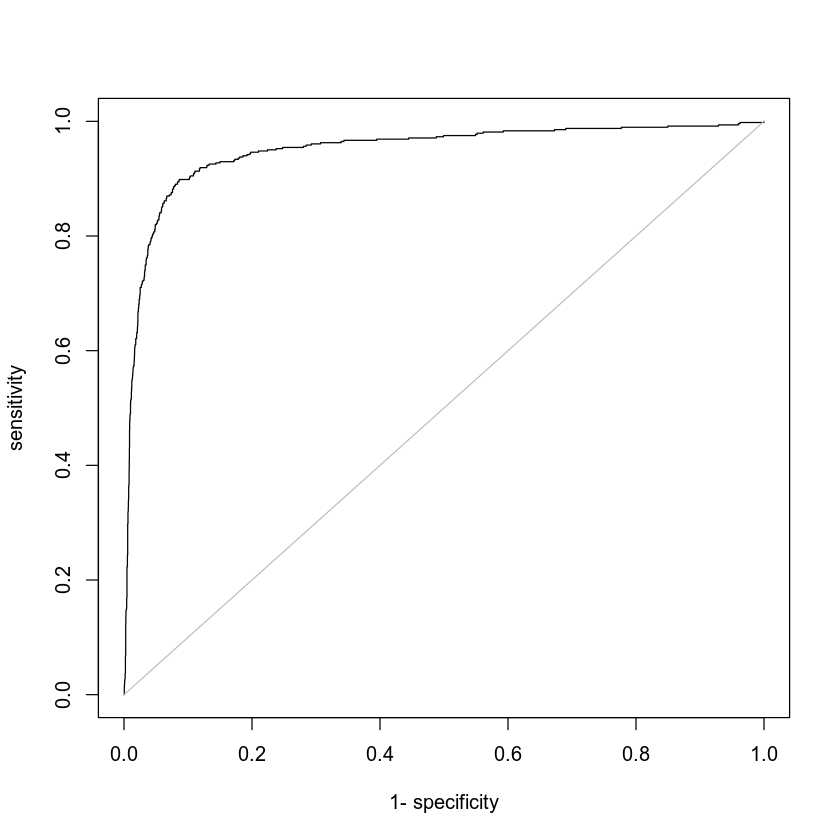

In [14]:
roc <-roc(out1, as.factor(datt[,1]))
table(datt[,1], outbin1)
diag(table(datt[,1], outbin1)) / length(outbin1)
auc(roc)
plot(roc)

<font color='blue'>***Ahora construimos un modelo de regresión logística utilizando la función 'glm' con la familia 'family = binomial(link = "logit")'***</font>

In [15]:
model1 <- glm(datT$y9~., data = datT, family = binomial(link = "logit"))


# Problemas de convergencia con tantas variables
# Coefficients: (138 not defined because of singularities)
# Tasa de acierto (Train)
out2 <- model1$fitted.values
outbin2 <- as.double(out2 > 0.5)
100*sum(diag(table(datT[,1], outbin2))) / length(outbin2)

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] 98.34

In [16]:
#hist(out2)

In [17]:
# Tasa de acierto (test)
out3<- predict(object=model1, newdata = datt);
outbin3 <- as.double(out3 > 0.5)
100*sum(diag(table(datt[,1], outbin3))) / length(outbin3)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] 92.22

<font color='blue'>***Las inestabilidades numéricas se producen por la alta dimensionalidad de los datos. Algunos de los coeficientes resultan redundantes y el proceso de optimización no converge.***</font>

### <font color='blue'>***(195 not defined because of singularities).***</font>

<font color='blue'>***Una solución a este problema es reducir la dimensionalidad del conjunto de predictores. Para ello existen técnicas eficientes (como los métodos de regularización o las Componentes Principales) que se verán más adelante. En esta práctica utilizamos un entresacado de información, considerando sólo uno de cada 20 pixeles.***</font>

In [18]:
# REGRESIÓN LINEAL
j<-seq(1,784,20)

# Entrenamos sobre el conjunto train
model <- lm(datT$y9~., data = datT[,j]) 
out <- model$fitted.values
outbin <- as.double(out > 0.5)
100*sum(diag(table(datT[,1], outbin))) / length(outbin)

# Validamos sobre test
out1<- predict(object=model, newdata = datt[,j]);
outbin1 <- as.double(out1 > 0.5)
100*sum(diag(table(datt[,1], outbin1))) / length(outbin1)

[1] 90.28

Warning message in predict.lm(object = model, newdata = datt[, j]):
“prediction from a rank-deficient fit may be misleading”


[1] 91.1

In [19]:
# REGRESIÓN LOGÍSTICA
j<-seq(1,784,20)

# Entrenamos sobre el conjunto train
model <- glm(datT$y9~., data = datT[,j], family = binomial(link = "logit"))
out <- model$fitted.values
outbin <- as.double(out > 0.5)
100*sum(diag(table(datT[,1], outbin))) / length(outbin)

# Validamos sobre test
out1<- predict(object=model, newdata = datt[,j]);
outbin1 <- as.double(out1 > 0.5)
100*sum(diag(table(datt[,1], outbin1))) / length(outbin1)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] 92.02

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”


[1] 92.26

## <font color='blue'>PRÁCTICA 1</font>
<font color='blue'>***Construir un modelo de clasificación para cada dígito, y obtener una ranking de los dígitos en base a su capacidad predictiva (el primero el que mejor se predice, etc.). Para evaluar la capacidad predictiva considerando el error de test obtenido al separar aleatoriamente la muestra en un conjunto de train (n=10000) y el resto de test.***</font>

<font color='blue'>***Nota: usar la función 'sample'.***</font> 
    
<font color='blue'>***Nota2: Elige un entresacado óptimo para que la capacidad predictiva no se reduzca y se reduzca la dimensión el máximo posible.***</font>

**¿Cómo elegir un entresacado óptimo?**, **¿qué píxeles seleccionar?** En el ejemplo propuesto, se considera la secuencia de enteros entre 1 y 784 con paso 1 y se elige uno de cada 20 píxeles. Si bien, parece demasiado aleatorio elegir unos píxeles a voleo. Por ello, antes de elegir los píxeles y dado que no podemos utilizar técnicas como métodos de regularización o componentes principales, llevaremos a cabo tres estrategias. Elegiremos la que proporcione mejor resultado.

1. Eliminación de márgenes + píxeles aleatorios.
2. Eliminación de márgenes + media con vecinos adyacentes + píxeles más valorados.
3. Eliminación de márgenes + suma de píxeles + píxeles más y menos valorados.


Considerar todos los posibles entresacados es inviable.

# Estrategia 1: eliminación de márgenes + pixeles aleatorios.

Para separar aleatoriamente la muestra (almacenada en la variable `x_train`) emplearemos la función `sample` de R: https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/sample.

En primer lugar, separamos la muestra `x_train` en un conjunto de entrenamiento de 10000 imágenes y un conjunto de test que contiene el resto. Dichos conjuntos son disjuntos:

**Mantendremos estos índices en TODO el ejercicio.**

In [20]:
# Indexes for train
set.seed(14)
idx.train <- sample(x = 1:nrow(x_train), size = 10000,  replace = F)

In [21]:
# Indexes for test
idx.test <- setdiff(x = 1:nrow(x_train), y = idx.train)

En el ejemplo propuesto, se emplea el entresacado `seq(1,784,20)` dando lugar a una selección de 40 píxeles. Por ello, consideraré que el número máximo de píxeles asumibles es 40. Es claro que, cuantos más píxeles consideremos, maś información tendremos, pero hemos de encontrar un balance entre tasa de acierto y dimensión del problema. 

En las estrategias que voy a considerar, es esperable que el mejor representante contenga 40 píxeles, pero consideraremos los resultados para 10, 20, 30 y 40 píxeles. 



Es de esperar que, en cada imagen, el dígito esté centrado. Por ello, elegir píxeles de los bordes de la imágen, puede resultar contraproducente. Quizá pueda resultar mejor escoger píxeles de la zona central de la imagen que, a priori, pueden resultar más significativos. Si bien, nada nos garantiza que los dígitos vayan a estar centrados; son sólo suposiciones. 



Para ver si esto se cumple, consideraremos todos los dígitos del 0 al 9. Para cada uno de los dígitos, creamos un vector binario `y.digit` de etiquetas (1 si se corresponde con el dígito considerado; 0 en caso contrario). Construimos el dataframe `data.digit` cuya primera columna es el vector de etiquetas y el resto de columnas se corresponde con los valores de los pixeles correspondientes al train. Dadas las imágenes del train que contienen el dígito que estamos estudiando, elegimos las 50 primeras (probar otros valores) y ploteamos qué valor contienen sus píxeles.

Trabajaremos únicamente con la muestra que tenemos de entrenamiento y se corresponde con las imágenes de los índices `idx.train`. Se supone que el test no lo podemos ver.

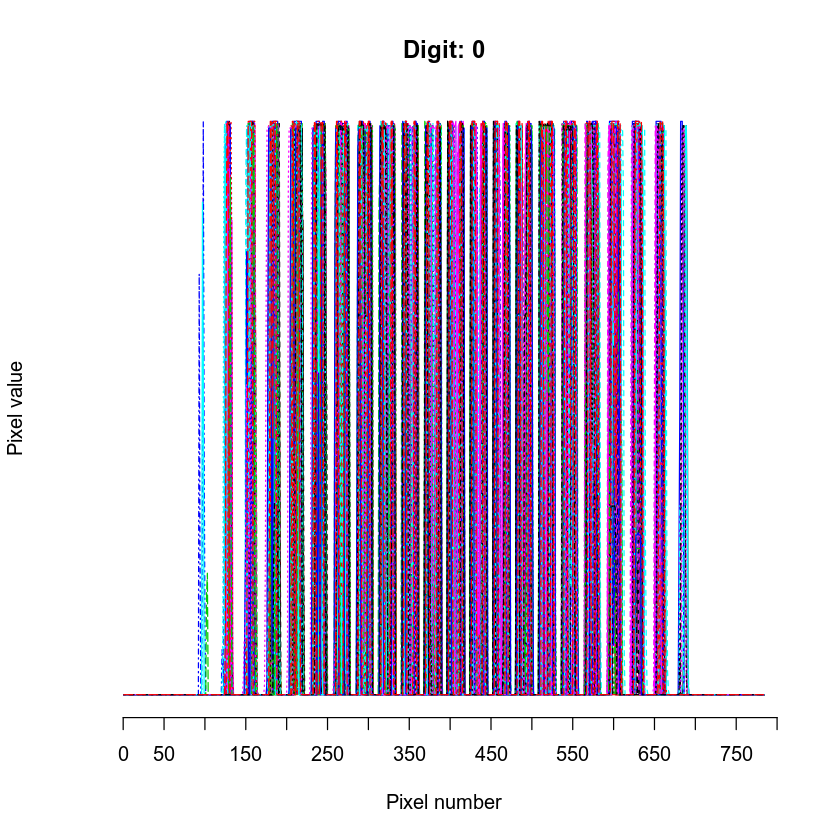

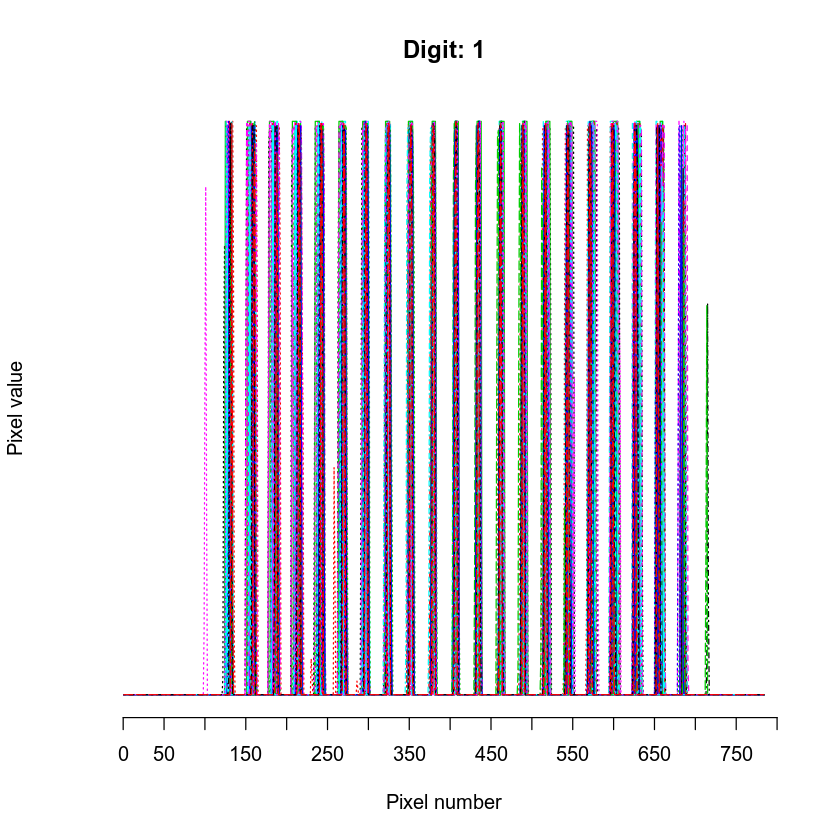

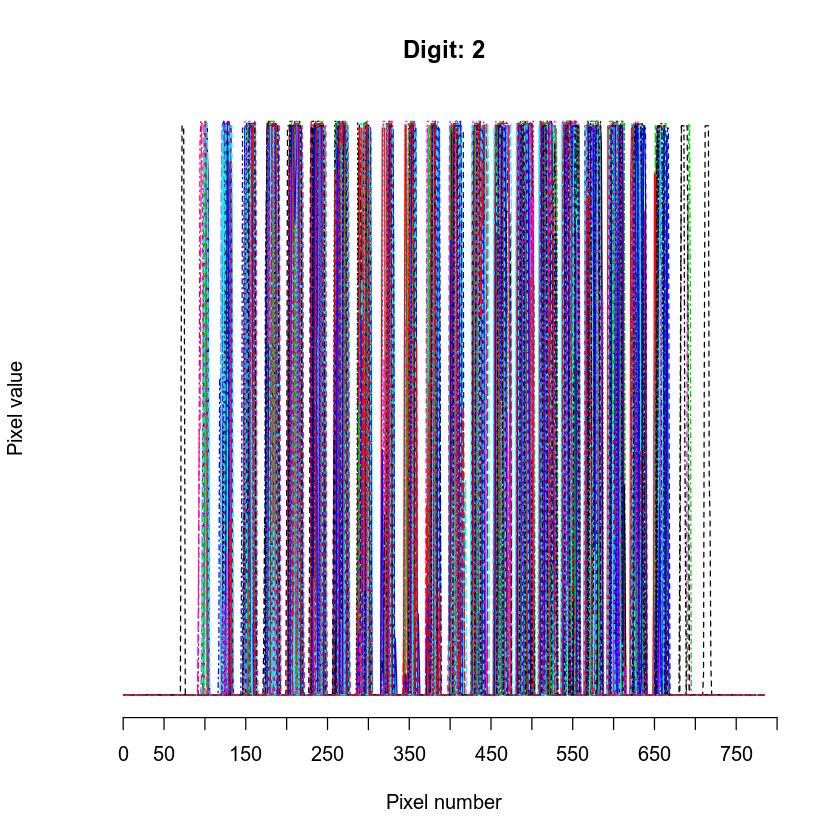

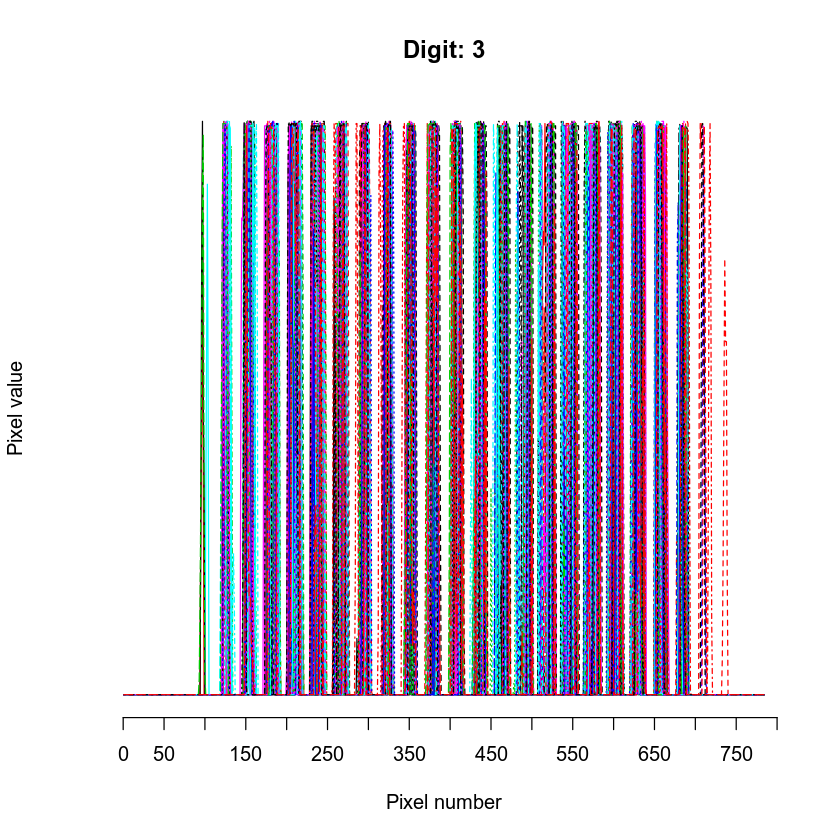

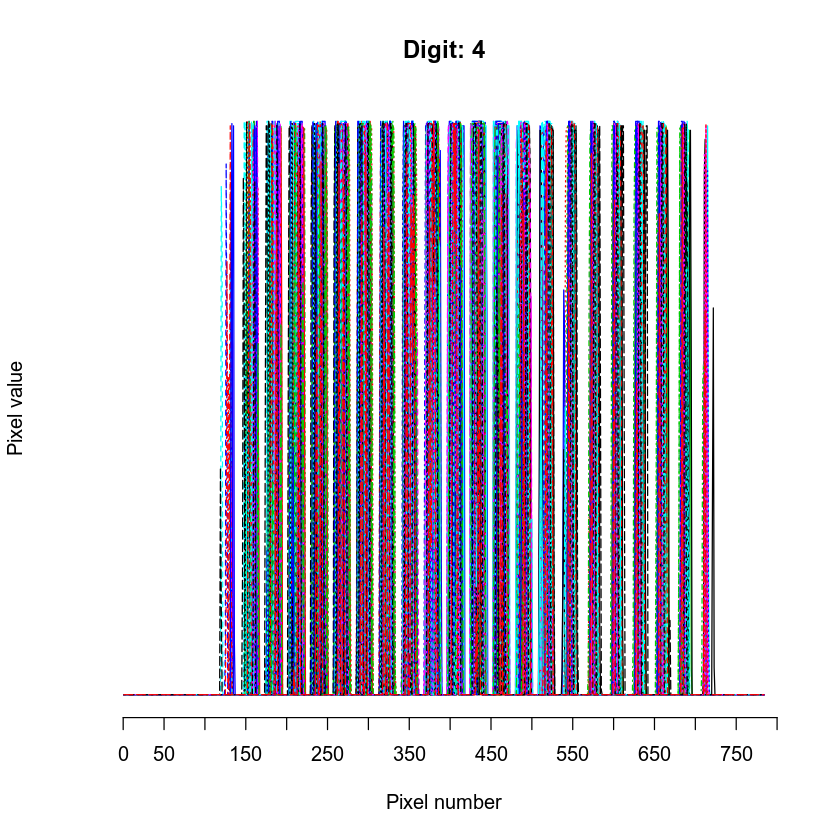

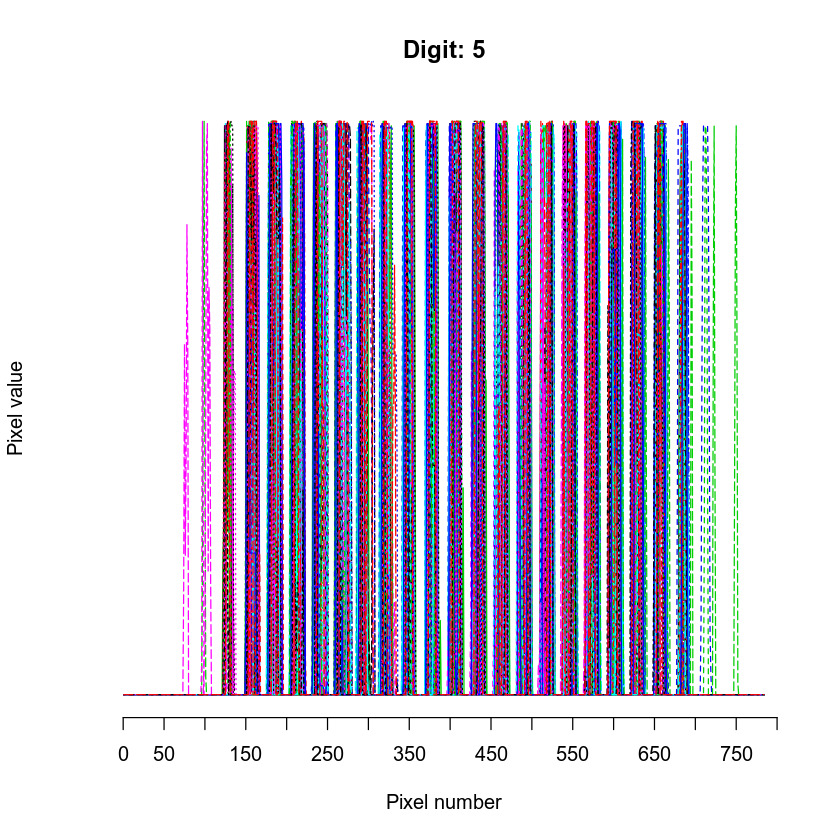

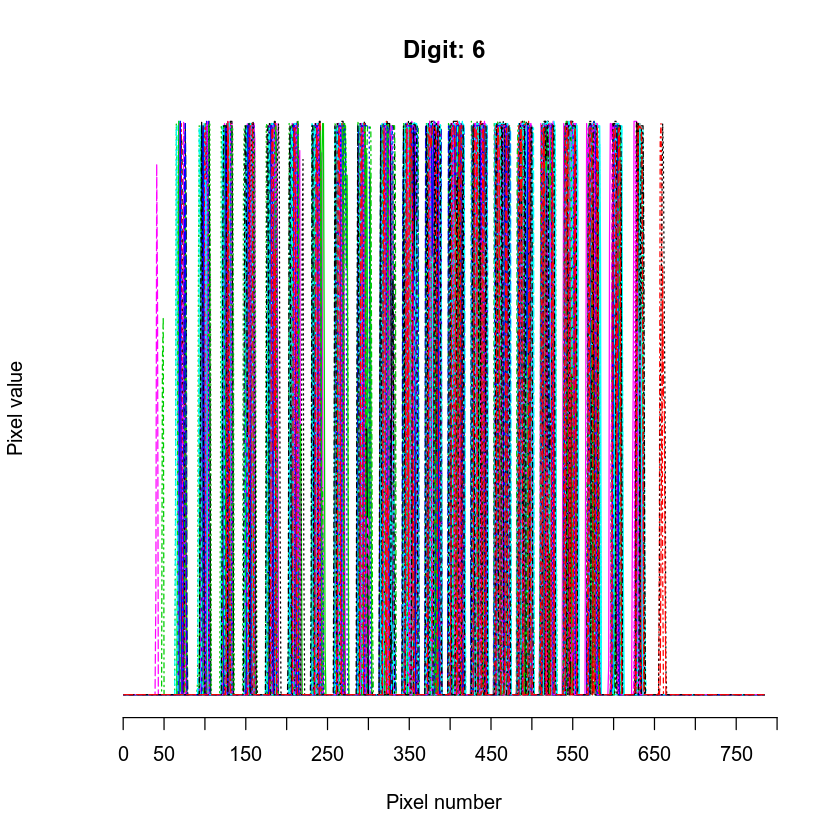

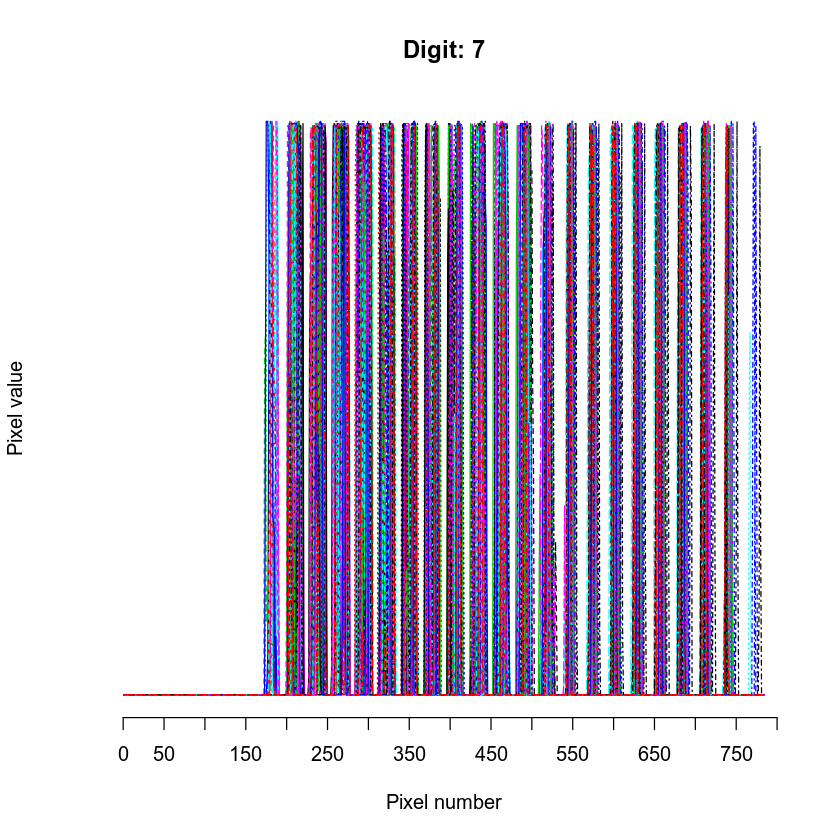

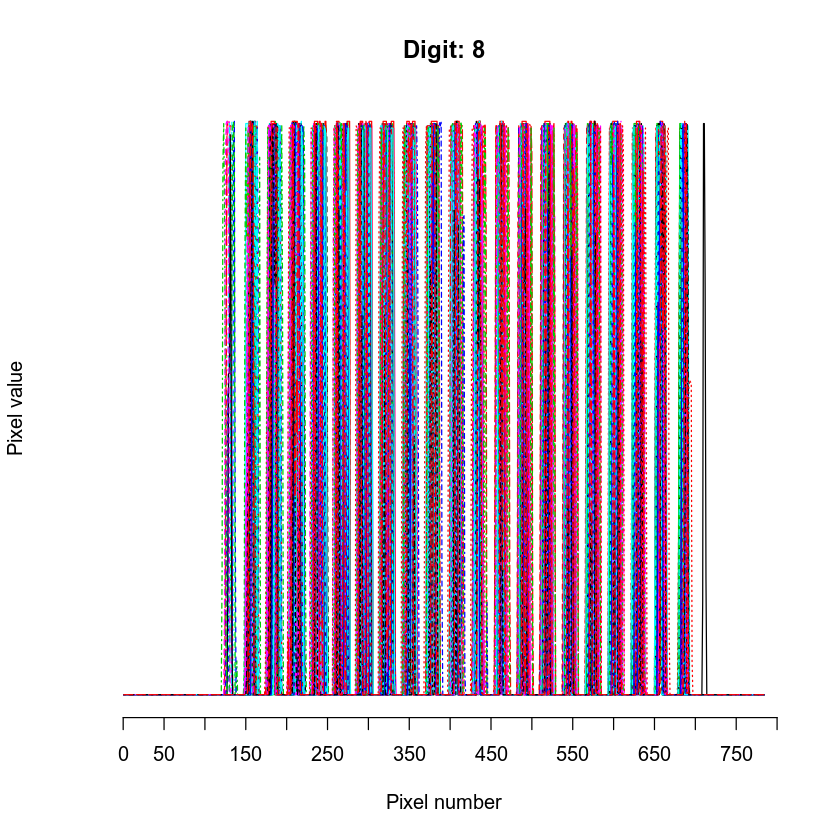

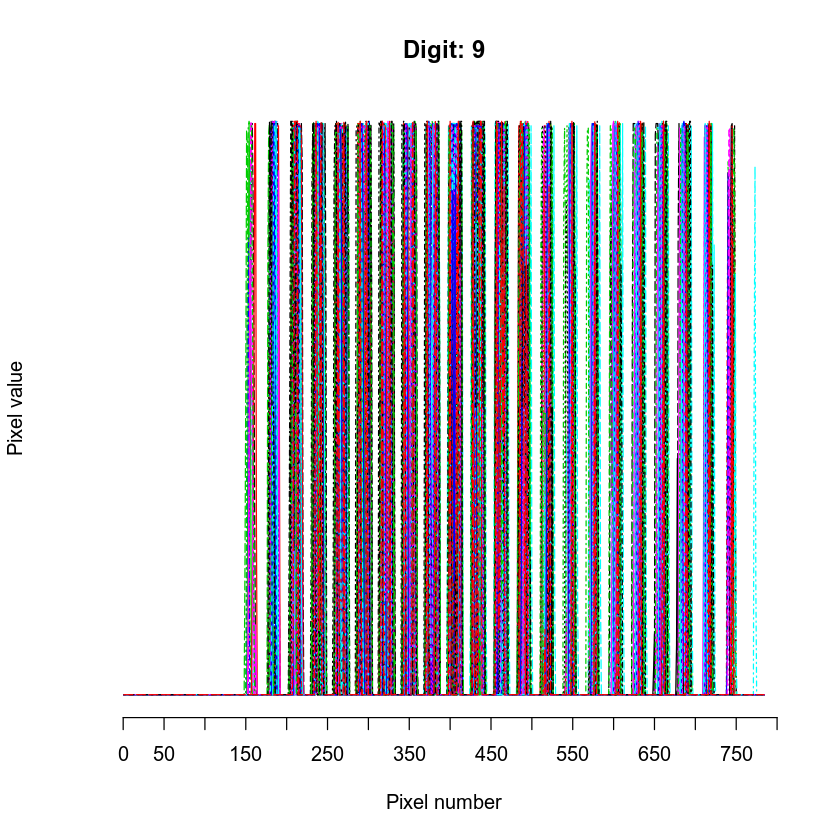

In [22]:
# Consider each digit
for (digit in 0:9){        

    # Select training labels
    y.digit <- y_train[idx.train]
    # Binary vector of labels
    y.digit[which(y_train[idx.train] != digit)] <- 0
    y.digit[which(y_train[idx.train] == digit)] <- 1
    
    # Create dataframe for digit: column 1: label; rest; pixel values
    data.digit <- data.frame(y.digit, x_train[idx.train, ])
    
    # Plot pixel values
    # We use the transpose as matplot plots the columns of one matrix against the columns of another.
    matplot(t(head(subset(data.digit, data.digit$y.digit == 1)[, -1], 50)),
            type = "l", axes = F,
            main = paste("Digit:", digit), ylab = "Pixel value", xlab = "Pixel number")
  
    # Set X-axis
    axis(side = 1, at = seq(0,800,50), labels = seq(0,800,50))
}

En la mayoría de los casos, podemos eliminar los píxeles de los márgenes, pues tienen valor 0. Las imágenes nos son dadas como listas de 784 elementos cuyos índices se corresponden con los enteros entre 1 y 784. Si entendemos las imágenes como matrices $28\times28$ de píxels, podemos hacer una correspondencia entre los índices de la lista y los de la matriz que se muestra a continuación. El elemento que ocupe el índice $k$ en la lista, estará en la posición cuyo valor sea $k$ en la siguiente matriz de índices:

\begin{bmatrix} 
	28\cdot0 + 1 & 28\cdot0 + 2 & ... & 28\cdot0 + 28 \\
	28\cdot1 + 1 & 28\cdot1 + 2 & ... & 28\cdot1 + 28 \\
    \vdots & \vdots \\
	28\cdot27 + 1 & 28\cdot27 + 1 & ... & 28\cdot27 + 28 
\end{bmatrix}

Cada posición es de la forma $k = 28\cdot i + j$ donde $i =0,1,...,27$, $j=1,2,...,28$:

In [23]:
matrix(seq(1,784,1), ncol = 28, byrow = T)

[,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11] [,12] [,13]
 [1,]   1    2    3    4    5    6    7    8    9   10   ...    19    20  
 [2,]  29   30   31   32   33   34   35   36   37   38   ...    47    48  
 [3,]  57   58   59   60   61   62   63   64   65   66   ...    75    76  
 [4,]  85   86   87   88   89   90   91   92   93   94   ...   103   104  
 [5,] 113  114  115  116  117  118  119  120  121  122   ...   131   132  
 [6,] 141  142  143  144  145  146  147  148  149  150   ...   159   160  
 [7,] 169  170  171  172  173  174  175  176  177  178   ...   187   188  
 [8,] 197  198  199  200  201  202  203  204  205  206   ...   215   216  
 [9,] 225  226  227  228  229  230  231  232  233  234   ...   243   244  
[10,] 253  254  255  256  257  258  259  260  261  262   ...   271   272  
[11,] 281  282  283  284  285  286  287  288  289  290   ...   299   300  
[12,] 309  310  311  312  313  314  315  316  317  318   ...   327   328  
[13,] 337  338  339  340  341  342  343  344  345  346   ...   355   356  
[14,] 365  366  367  368  369  370  371  372  373  374   ...   383   384  
[15,] 393  394  395  396  397  398  399  400  401  402   ...   411   412  
[16,] 421  422  423  424  425  426  427  428  429  430   ...   439   440  
[17,] 449  450  451  452  453  454  455  456  457  458   ...   467   468  
[18,] 477  478  479  480  481  482  483  484  485  486   ...   495   496  
[19,] 505  506  507  508  509  510  511  512  513  514   ...   523   524  
[20,] 533  534  535  536  537  538  539  540  541  542   ...   551   552  
[21,] 561  562  563  564  565  566  567  568  569  570   ...   579   580  
[22,] 589  590  591  592  593  594  595  596  597  598   ...   607   608  
[23,] 617  618  619  620  621  622  623  624  625  626   ...   635   636  
[24,] 645  646  647  648  649  650  651  652  653  654   ...   663   664  
[25,] 673  674  675  676  677  678  679  680  681  682   ...   691   692  
[26,] 701  702  703  704  705  706  707  708  709  710   ...   719   720  
[27,] 729  730  731  732  733  734  735  736  737  738   ...   747   748  
[28,] 757  758  759  760  761  762  763  764  765  766   ...   775   776  
      [,14] [,15] [,16] [,17] [,18] [,19] [,20] [,21]
 [1,]  21    22    23    24    25    26    27    28  
 [2,]  49    50    51    52    53    54    55    56  
 [3,]  77    78    79    80    81    82    83    84  
 [4,] 105   106   107   108   109   110   111   112  
 [5,] 133   134   135   136   137   138   139   140  
 [6,] 161   162   163   164   165   166   167   168  
 [7,] 189   190   191   192   193   194   195   196  
 [8,] 217   218   219   220   221   222   223   224  
 [9,] 245   246   247   248   249   250   251   252  
[10,] 273   274   275   276   277   278   279   280  
[11,] 301   302   303   304   305   306   307   308  
[12,] 329   330   331   332   333   334   335   336  
[13,] 357   358   359   360   361   362   363   364  
[14,] 385   386   387   388   389   390   391   392  
[15,] 413   414   415   416   417   418   419   420  
[16,] 441   442   443   444   445   446   447   448  
[17,] 469   470   471   472   473   474   475   476  
[18,] 497   498   499   500   501   502   503   504  
[19,] 525   526   527   528   529   530   531   532  
[20,] 553   554   555   556   557   558   559   560  
[21,] 581   582   583   584   585   586   587   588  
[22,] 609   610   611   612   613   614   615   616  
[23,] 637   638   639   640   641   642   643   644  
[24,] 665   666   667   668   669   670   671   672  
[25,] 693   694   695   696   697   698   699   700  
[26,] 721   722   723   724   725   726   727   728  
[27,] 749   750   751   752   753   754   755   756  
[28,] 777   778   779   780   781   782   783   784

A la vista de las gráficas anteriores, parece que podemos eliminar las primeras 4 filas (correspondientes a los píxeles $1,2,...,28\cdot4$) y las últimas y columnas (correspondientes a los píxeles $28\cdot24+1,...,28\cdot27 +28$).

También vamos a elminar las columnas laterales. Eliminaremos los píxeles de los índices $28\cdot i + j$ para $i=4,5,6,..,23$, $j=1,2,3,4,25,26,27,28$.

In [24]:
# Indexes for bounds
del <- c()                          # Empty vector to store pixels
del <- c(del, 1:(28*4))             # Indexes for first rows
del <- c(del, (28*24 + 1):(28*28))  # Indexes for last rows 
for (i in 4:23){                    # Indexes for columns 28*i + j 
    for (j in (c(1:4, 25:28)))      # Indexes for columns 28*i + j 
        del <- c(del, 28*i + j)
}

In [25]:
del

[1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
 [19]  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
 [37]  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
 [55]  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
 [73]  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
 [91]  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
[109] 109 110 111 112 673 674 675 676 677 678 679 680 681 682 683 684 685 686
[127] 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701 702 703 704
[145] 705 706 707 708 709 710 711 712 713 714 715 716 717 718 719 720 721 722
[163] 723 724 725 726 727 728 729 730 731 732 733 734 735 736 737 738 739 740
[181] 741 742 743 744 745 746 747 748 749 750 751 752 753 754 755 756 757 758
[199] 759 760 761 762 763 764 765 766 767 768 769 770 771 772 773 774 775 776
[217] 777 778 779 780 781 782 783 784 113 114 115 116 137 138 139 140 141 142
[235] 143 144 165 166 167 168 169 170 171 172 193 194 195 196 197 198 199 200
[253] 221 222 223 224 225 226 227 228 249 250 251 252 253 254 255 256 277 278
[271] 279 280 281 282 283 284 305 306 307 308 309 310 311 312 333 334 335 336
[289] 337 338 339 340 361 362 363 364 365 366 367 368 389 390 391 392 393 394
[307] 395 396 417 418 419 420 421 422 423 424 445 446 447 448 449 450 451 452
[325] 473 474 475 476 477 478 479 480 501 502 503 504 505 506 507 508 529 530
[343] 531 532 533 534 535 536 557 558 559 560 561 562 563 564 585 586 587 588
[361] 589 590 591 592 613 614 615 616 617 618 619 620 641 642 643 644 645 646
[379] 647 648 669 670 671 672

Con esto, estamos eliminando 384 píxeles.

In [26]:
length(del)

[1] 384

Nos quedamos con los píxels "centrales", que son 400:

In [27]:
pixels.centre <- setdiff(1:748, del)

In [28]:
length(pixels.centre)

[1] 400

Una vez seleccionados los $400$ píxeles centrales, elegiremos un número aleatorio de estos como entresacado.

Creamos una función que implementa esta estrategia. La función `strategy.1` recibe como input:
* j: índices de los píxeles seleccionados;
* indexes.train: índices para la muestra de train;
* indexes.test: índices para la muestra de test.

Los pasos que realiza son:
* Crear listas vacías para almacenar accuracy en test y train;
* Para cada dígito:
    * Crear vectror binario de etiquetas;
    * Crear dataframe con etiquetas biniarias y píxeles;
    * Separar en conjuntos de train y test;
    * Aplicar regresión logística;
    * Calcular precisión sobre el conjunto de train;
    * Calcular precisión sobre el conjunto de test.
* Devolver dataframe con dos columnas: precisión sobre train y precisión sobre test; y 10 filas, una para cada dígito 0,...,9.


In [29]:
strategy.1 <- function(j, indexes.train, indexes.test){
    
    #
    # Function for 1st strategy: remove bounds and select random pixels. 
    #
    # @description: Function for 1st strategy: remove bounds and select random pixels.
    #
    # @param j: numeric vector. Vector of selected pixels.
    # @param indexes.train: numeric vector. Vector of indexes for training sample.
    # @param indexes.test: numeric vector. Vector of indexes for test sample.
    #
    # @return: dataframe. Dataframe 10x2. First column: accuracy on train. Second column: accuracy in test.
    # Rows 1,...,10 are correspond to digits 0,...,9 resp.
    #
    
    # List to store accuracy for train
    acc.train.bounds <- c()

    # List to store accuracy for test
    acc.test.bounds <- c()

    # Consider each digit
    for (digit in 0:9){
    
        # Binary vector for labels
        y.digit <- y_train
        y.digit[which(y_train != digit)] <- 0
        y.digit[which(y_train == digit)] <- 1
        
        # Create dataframe
        data.digit <- data.frame(y.digit, x_train)
        
        # Train set
        data.digit.train <- data.digit[indexes.train, ]
        # Test set
        data.digit.test <- data.digit[indexes.test, ]
    
        # Logistic regression
        model.digit <- glm(data.digit.train$y.digit ~ . ,
                           data = data.digit.train[, j],
                           family = binomial(link = "logit"))
    
        # ANALYSIS FOR PERFORMANCE ON TRAIN
        out.train <- model.digit$fitted.values
        # Binary output
        out.bin.train <- as.double(out.train > 0.5)
        # Binary accuracy
        acc.digit.train <- 100 * sum(diag(table(data.digit.train[, 1], out.bin.train))) / length(out.bin.train)
        acc.train.bounds <- c(acc.train.bounds, acc.digit.train)
        # cat(sprintf("Binary accuracy for digit %s on training data: %s \n", digit, acc.digit.train))
    
    
        # ANALYSIS FOR PREDICTION ON TEST
        out.test <- predict(object = model.digit, newdata = data.digit.test[, j]);
        # Binary output
        out.bin.test <- as.double(out.test > 0.5)
        # Binary accuracy
        acc.digit.test <- 100 * sum(diag(table(data.digit.test[, 1], out.bin.test))) / length(out.bin.test)
        acc.test.bounds <- c(acc.test.bounds, acc.digit.test)
        # cat(sprintf("Binary accuracy for digit %s on test data: %s \n", digit, acc.digit.test))
    
    }
    
    return(data.frame(train = acc.train.bounds, test = acc.test.bounds))
}


Creamos una función para mostrar gráficos:

In [30]:
plotter <- function(train, test, n.pixels, n.strategy){
    
    #
    # @description: plotter function. PLot test and train accuracy for each digit.
    #
    # @param train: numeric vector 10x1. Accuracy on train data for digits0,...,9.
    # @param test:  numeric vector 10x1. Accuracy on test data for digits 0,...,9.
    # @pram n.pixels: int. Number of selected pixels.
    # @param n.strategy: int {1,2,3}. Number of strategy.
    #
    # @return None.
    #
    
    # Plot binary accuracy for predictions on train
    plot(0:9, train, pch = 19, type = 'b', col = 'red', ylim = c(min(train, test), max(train, test)),
         ylab = "Binary accuracy", xlab = "Digit", 
         main = paste("Strategy:", n.strategy, ";", "Number of pixels:", n.pixels))

    # Plot binary accuracy for predictions on test
    lines(0:9, test, pch = 19, type = 'b', col = "blue")

    # Add legend
    legend("topright", legend = c("Train", "Test"), lty = 1, col = c("red", "blue"),  ncol = 1, xpd = T, inset = c(-0.5,0))
}

En el ejemplo propuesto, se seleccionaban 1 de cada 20 pixeles, quedando una selección de 40. Ese era el entresacado. Dados los píxeles centrales, elegiremos, al azar, 10, 20, 30, 40 pixels:

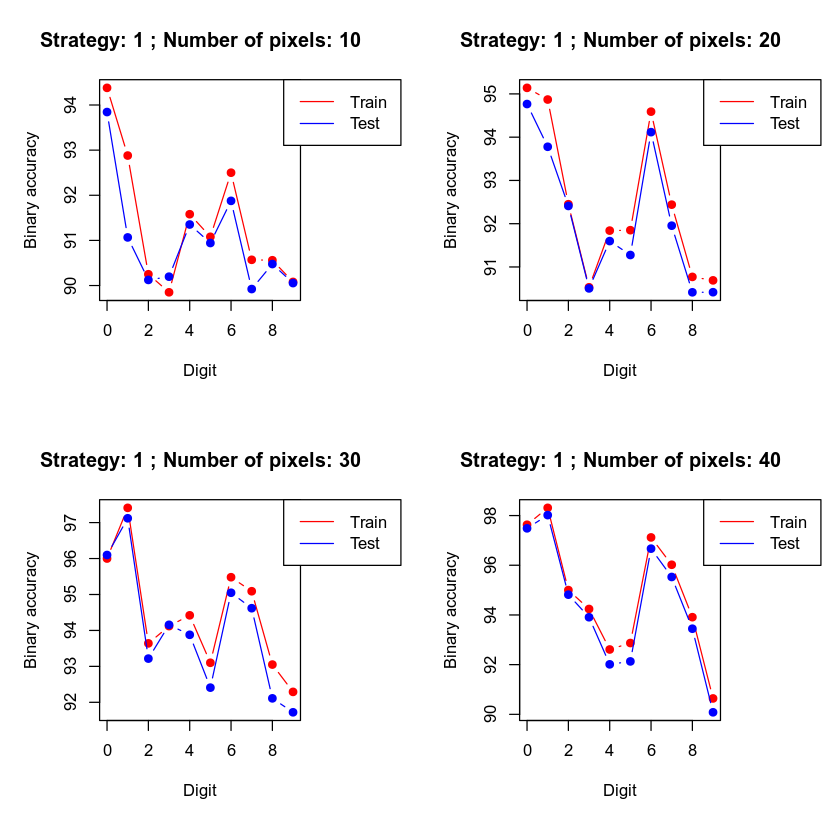

In [31]:
oldw <- getOption("warn")
options(warn = -1)

# Divide plot window
par(mfrow = c(2, 2))

# Empty list to sttore results
df.st.1 <- list()

i <- 1

# Consider 10, 20, 30, 40 pixels. CHANGE IF DESIRED.
for (n in seq(10,40,10)){
    
    # Select n random central pixels 
    index.temp <- sample(pixels.centre, n, replace = F)
    
    # Apply 1st strategy
    df.temp <- strategy.1(j = index.temp, idx.train, idx.test)
    
    # add to list. What if pixels are not 10,20,30,40? Index i is needed
    # df.st.1[[n / 10]] <- df.temp
    df.st.1[[i]] <- df.temp
    
    # Update 
    i <- i + 1
    
    # Plot 
    opar <- par(no.readonly = TRUE)
    par(mar = c(6, 5, 4, 6))
    plotter(df.temp$train, df.temp$test, n, 1)
}

options(warn = oldw)

Ploteamos sólo el accuracy sobre el test comparando según número de pixels:

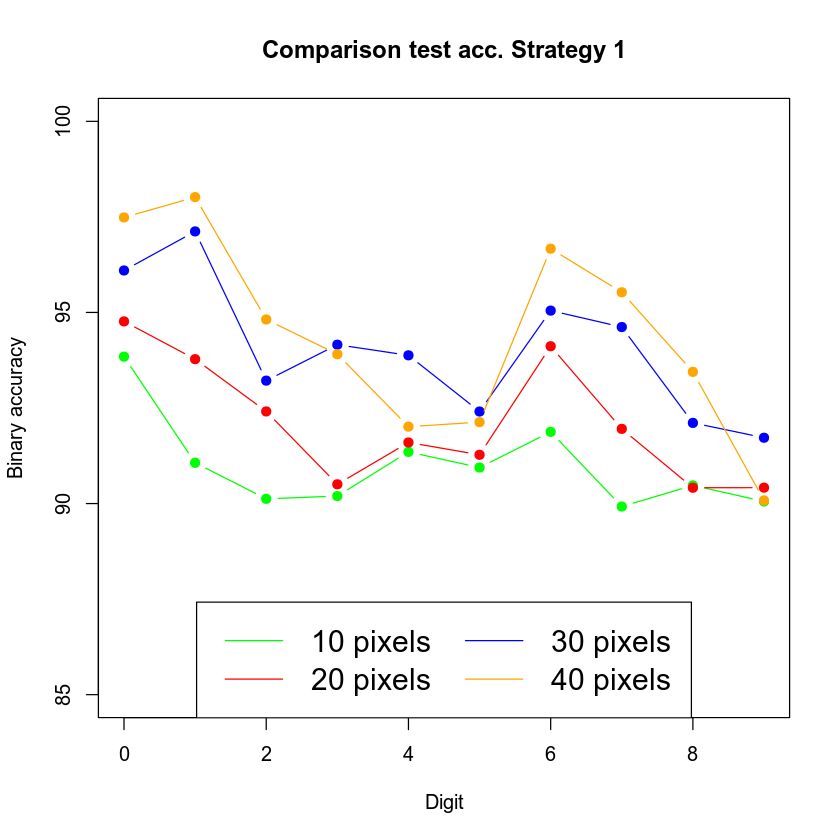

In [32]:
colors = c("green", "red", "blue", "orange")

plot(NULL, xlab = "Digit", ylab = "Binary accuracy", xlim = c(0,9), ylim = c(85,100),
     main = "Comparison test acc. Strategy 1")

for (i in 1:length(df.st.1)){
    lines(0:9, df.st.1[[i]]$test, col = colors[i], pch = 19, type = 'b',)
}

legend("bottom", legend = paste(seq(10,40,10), "pixels"),
               lty = 1, col = colors, cex = 1.5, ncol = 2)

Observamos que para 30 y 40 píxeles los resultados van intercalándose. En lugar de emplear $M$ píxeles aleatorios, ¿podemos filtrar de algún modo?

En la eliminación de los márgenes, hemos despreciado las 4 primeras columnas, las 4 últimas columnas, las 4 primeras filas, las 4 ultimas filas.

Por ello, tenemos índices que toman valores $\{28\cdot i + j\}_{i=4,5,...,23; j=5,6,...,24}$. Quizá podamos emplear las propiedades de los índices en cuando a artimética en módulo 28. 

Seleccionemos, para obtener 40, los píxeles de las columnas correspondientes a $j=11,22$.

In [33]:
z.1 = ((pixels.centre %% 28) %% 11) == 0

In [34]:
pixels.centre[z.1]

[1] 123 134 151 162 179 190 207 218 235 246 263 274 291 302 319 330 347 358 375
[20] 386 403 414 431 442 459 470 487 498 515 526 543 554 571 582 599 610 627 638
[39] 655 666

Veamos qué tal entresecado es el resultante de quitar márgenes y quedarnos con las columnas $j=11,22$

In [35]:
oldw <- getOption("warn")
options(warn = -1)

nobounds.11.22 <- strategy.1(j = pixels.centre[z.1], idx.train, idx.test)

options(warn = oldw)

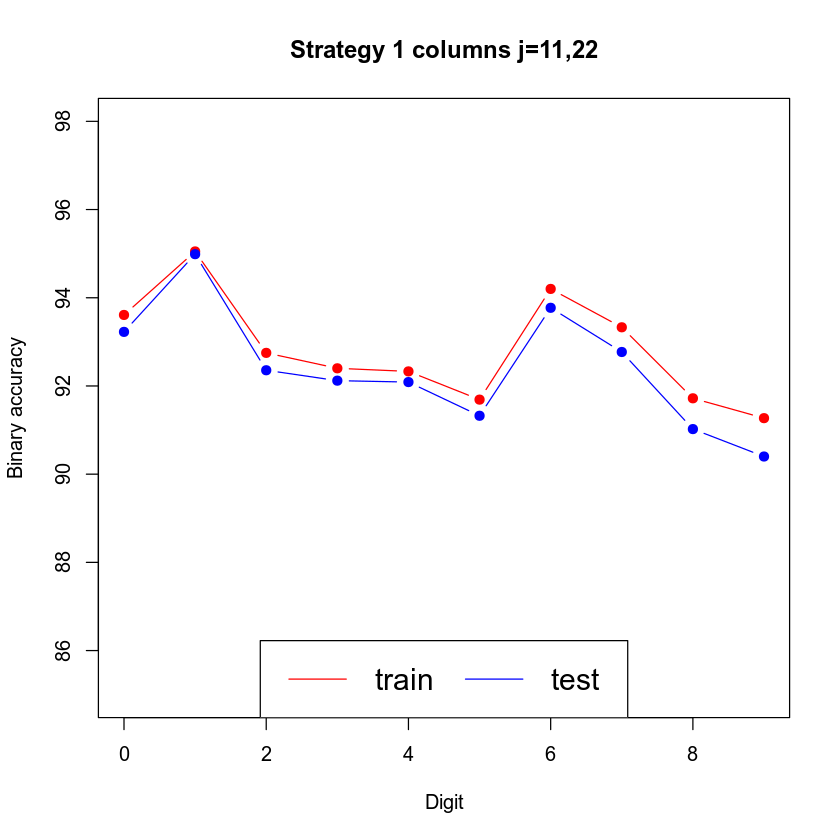

In [36]:
plot(0:9, nobounds.11.22$train,  pch = 19, type = 'b', ylim = c(85,98),
     main = "Strategy 1 columns j=11,22", ylab = "Binary accuracy", xlab = "Digit", col = "red")

lines(0:9, nobounds.11.22$test, col = "blue",  pch = 19, type = 'b')

legend("bottom", legend = c("train", "test"),  lty = 1, col = c("red","blue"), cex = 1.5, ncol = 2)

Seleccionemos, para tener 40 píxeles de dos columnas $j=13,21$ (podríamos coger otros valores):

In [37]:
z.2 = ((pixels.centre %% 28) %% 12) == 1 | ((pixels.centre %% 28) %% 20) == 1

In [38]:
oldw <- getOption("warn")
options(warn = -1)

nobounds.13.21 <- strategy.1(j = pixels.centre[z.2], idx.train, idx.test)

options(warn = oldw)

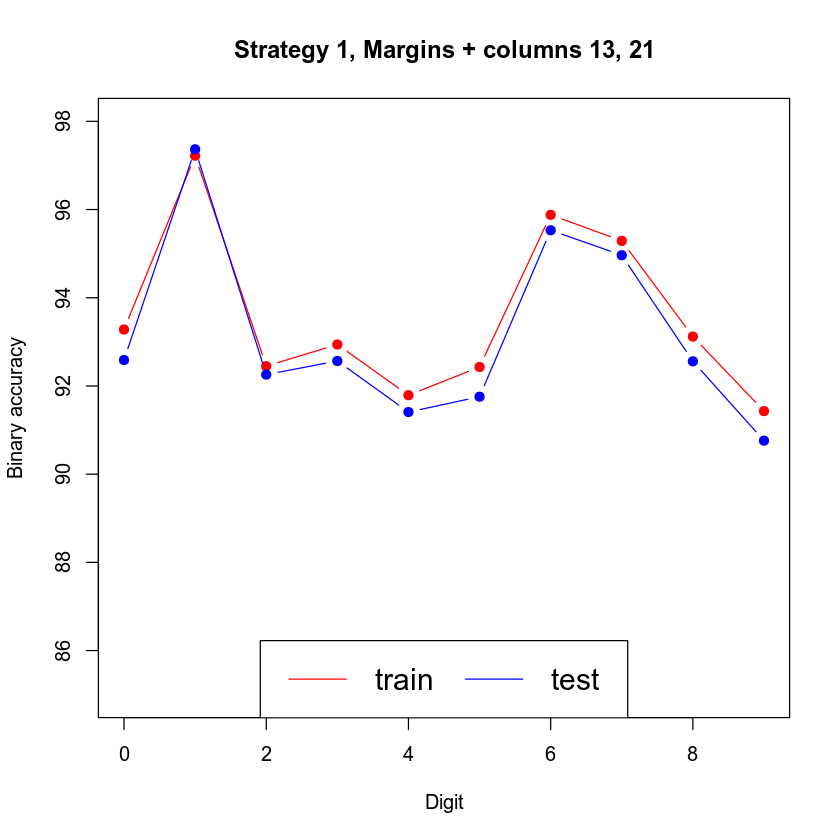

In [39]:
plot(0:9, nobounds.13.21$train, ylim = c(85,98), pch = 19, type = 'b', col = 'red',
     main = "Strategy 1, Margins + columns 13, 21", ylab = "Binary accuracy", xlab = "Digit")

lines(0:9, nobounds.13.21$test, col = "blue", pch = 19, type = 'b')

legend("bottom", legend = c("train", "test"),  lty = 1, col = c("red","blue"), cex = 1.5, ncol = 2)

Comparamos:

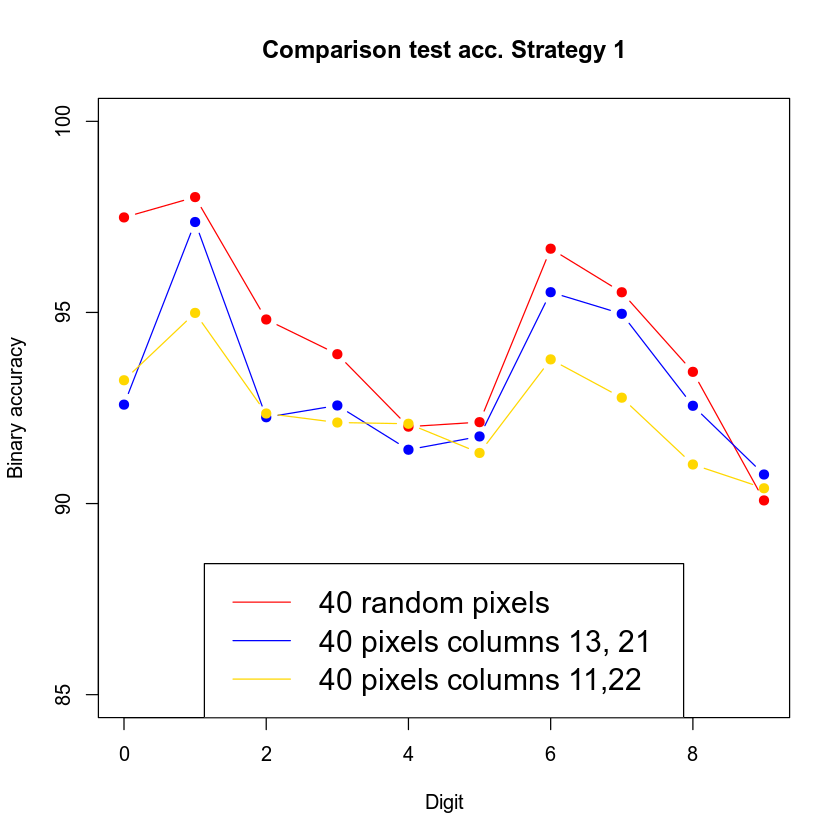

In [40]:
plot(NULL, xlab = "Digit", ylab = "Binary accuracy", xlim = c(0,9), ylim = c(85,100),
     main = "Comparison test acc. Strategy 1")

lines(0:9, df.st.1[[4]]$test,   col = "red",  pch = 19, type = 'b')
lines(0:9, nobounds.13.21$test, col = "blue", pch = 19, type = 'b')
lines(0:9, nobounds.11.22$test,    col = "gold", pch = 19, type = 'b')

legend("bottom", legend = c("40 random pixels", "40 pixels columns 13, 21", "40 pixels columns 11,22"),
               lty = 1, col = c("red","blue", "gold"), cex = 1.5)

Puesto que hay múltiples combinaciones a la hora de filtrar por columnas (o filas), escojo como **representante de esta estrategia 40 pixeles aleatorios dentro de los pixeles centrales.**

# Estrategia 2: media de adyacentes + eliminar márgenes + píxeles más altos.

Supongamos que tenemos una matriz con el valor de los píxeles para cada imagen. Para cada una de las entradas, consideraremos la propia entrada y los elementos adyacentes en diagonal, vertical y horizontal. Dada una entrada,  sumaremos el valor de todos los píxeles adyacentes a esta (que existan) y el valor de la propia entrada. El valor de la entrada central, lo sustituiremos por la media de los valores considerados.

Hemos de tener en cuenta que no todas las entradas de la matriz tienen el mismo número de vecinos adyacentes. Supongamos una matriz: 

\begin{bmatrix} 
	a_{11}  & a_{12}  & ... & a_{1M} \\
	a_{21}  & a_{22}  & ... & a_{2M} \\
    \vdots & \vdots & ... &  \vdots \\
	a_{N1}  & a_{N2}  & ... & a_{NM} \\
\end{bmatrix}

Por ejemplo:
* La entrada $a_{11}$ sólo tiene como vecinos adyacentes: $a_{12}$,$a_{21}$,$a_{22}$.
* La entrada $a_{12}$ sólo tiene como vecinos adyacentes: $a_{11}$,$a_{21}$,$a_{22}$,$a_{23}$,$a_{13}$.

Una posibilidad es implementr un algoritmo que distinga por casos: si el número de la fila o columna se sale o no de los límites, entonces considerar tales vecinos. Otra opción es añadir una columna de ceros por la derecha y la izquierda; una fila de ceros por arriba y por abajo de la matriz original, de modo que resulte:


\begin{bmatrix} 
    0  & 0  & 0  & ... & 0 & 0 \\
	0  &a_{11}  & a_{12}  & ... & a_{1M} & 0 \\
	0  &a_{21}  & a_{22}  & ... & a_{2M} & 0 \\
    0  &\vdots & \vdots & ... &  \vdots & 0 \\
	0  &a_{N1}  & a_{N2}  & ... & a_{NM} & 0 \\
    0  & 0 & 0 & ... & 0 & 0 \\
\end{bmatrix}

De este modo, recorreríamos sólo la matriz central que nos interesa y no haríamos distinciones en cuanto a vecinos adyacentes. Todas las entradas tienen 8 vecinos (más ella misma).

Esto iría en contra de la tendencia habitual de mejorar algoritmos en lugar de aumentar objetos almacenados, pero no supone un gran drama en lo que pretendo hacer.

In [41]:
avg.neighbors <- function(mat){
    
    #
    # @desciption: for each entry of the input matrix, compute average with its adjacent neighbors.
    #
    # @param mat: numeric matrix.
    #
    # @return: numeric matrix. Average for entries
    #
    
    # Empty matrix to store mean values
    mymatavg <- c()
    
    # Add columns and rows with 0s
    mat = cbind(mat, 0)
    mat = cbind(0, mat)
    mat = rbind(0, mat)
    mat = rbind(mat, 0)
    
    # Central matrix
    for (i in (2:(nrow(mat)-1))){
        for (j in (2:(ncol(mat)-1))){
        
            # Select entries
            my_values <- c(mat[i,j], mat[(i-1),j-1], mat[(i-1),j+1],
                           mat[(i-1),j], mat[i,j+1], mat[i,j-1],
                           mat[(i+1),j], mat[(i+1),j-1], mat[(i+1),j+1])
        
            # Mean value
            mymatavg = c(mymatavg, sum(my_values) / sum(my_values != 0, na.rm = T))
        }
    }
    
    return(matrix(mymatavg, ncol = ncol(mat)-2))
    
}


Ejemplo de aplicación:

In [42]:
mymat2 = c(3,1,6,1,1,1,6,1,5)
mymat2= matrix(mymat2, ncol = 3)
mymat2

[,1] [,2] [,3]
[1,] 3    1    6   
[2,] 1    1    1   
[3,] 6    1    5

In [43]:
avg.neighbors(mymat2)

[,1]     [,2]     [,3]
[1,] 1.500000 2.166667 2.25
[2,] 2.166667 2.777778 2.50
[3,] 2.250000 2.500000 2.00

Para llevar a cabo esta estrategia, consideraremos todos los dígitos. Para cada uno de los dígitos, buscamos 50 imágenes del train que lo contengan. Inicializamos una matriz de ceros 28x28 que irá acumulando los resultados. Para cada una de las imágenes consideradas, aplicamos la media de adyacentes y sumamos la matriz resultante a la que inicializamos anteriormente. De este modo, la matriz inicial de ceros habrá acumulado la suma de las 50 matrices resultantes de aplicar la media de adyacentes. En esa matriz, seleccionamos las N entradas (píxeles) de mayor valor que no están en los márgenes.

La función `strategy.2`, que implementa la estrategia 2, recibe el número $N$ de píxeles que queremos. Para cada dígito:
* Crea el vector binario de etiquetas;
* Crea el dataframe asociado;
* Para las etiquetas verdadereas del suconjunto de idx.train, aquellas que se sorresponden con el dígito que estamos considerando, selecciona 50 imágenes aleatorias. Cambiar el número si se desea. Consideraremos los de idx.train porque no podemos mirar el test;
* Crea una matriz vacía;
* Aplica la media de adyacentes a cada imagen y sumar la matriz obtenida a la matriz anteriormente construida. Dicha matriz inicialmente sólo contiene 0s y será la suma de las 50 matrices resultantes de aplicar la media en las 50 imágenes consideradas;
* Dada la matriz que acumula resultados, seleccionar índices para los N valores mayores de los píxeles y eliminar si están en los márgenes;
* Aplicar regresión logística como habitualmente.

*Podríamos primero quitar márgenes y luego aplicar la media de adyacentes. Pero, posteriormente habría que mapaear los índices da la matriz resultante de eliminar márgenes en los índices de la original ¿qué función hace eso? ¿Alguna que tenga en cuenta divisores i y restos j ?*

In [44]:
strategy.2 <- function(N, indexes.train, indexes.test){
    
    #
    # Function for 2nd strategy: remove bounds + adjacent neighbors + N maximum pixels. 
    #
    # @description: Function for 1st strategy: remove bounds and select random pixels.
    #
    # @param N: int. Number of desired pixels.
    # @param indexes.train: numeric vector. Vector of indexes for training sample.
    # @param indexes.test: numeric vector. Vector of indexes for test sample.
    #
    # @return: dataframe. Dataframe 10x2. First column: accuracy on train. Second column: accuracy in test.
    # Rows 1,...,10 are correspond to digits 0,...,9 resp.
    #
    
    # Store accuracy for train
    acc.train <- c()
    
    # Store accuracy for ttst
    acc.test <- c()
    
    # Consider each digit
    for (digit in 0:9){
        
        # Binary vector for labels
        y.digit <- y_train
        y.digit[which(y_train != digit)] <- 0
        y.digit[which(y_train == digit)] <- 1
        
        # Create dataframe
        data.digit <- data.frame(y.digit, x_train)
        
        # Train and test set
        data.digit.train <- data.digit[indexes.train, ]
        data.digit.test <- data.digit[indexes.test, ]
    
        # For those who truly are the digit we are condidering, select the first 50 images
        # Change 50 for other number if desired
        data.digit.true = subset(data.digit.train, 
                                 data.digit.train$y.digit == 1)[sample(nrow(subset(data.digit.train,
                                                             data.digit.train$y.digit == 1)), 50, replace = F), ]
    
        # Apply average for adjacent neighbors and sum in result matrix
        sums <- matrix(rep(0, 28*28), ncol = 28)
        for (n in 1:nrow(data.digit.true)){
            sums <- sums + avg.neighbors(matrix(as.matrix(data.digit.true[n, -1]), ncol = 28))
        }
    
        
        # Remove bounds + Indexes for first N maximum pixels values 
        j <- setdiff(order(as.numeric(as.list(t(sums))), decreasing = T), del)
        j <- j[1:N]
    
        # Logistic regression
        model.digit <- glm(data.digit.train$y.digit ~ .,
                           data = data.digit.train[, j],
                           family = binomial(link = "logit"))
    
        # Analysis for prediction on train
        out.train <- model.digit$fitted.values
        out.bin.train <- as.double(out.train > 0.5)
        # Binary accuracy
        acc.digit.train <- 100*sum(diag(table(data.digit.train[, 1], out.bin.train))) / length(out.bin.train)
        acc.train <- c(acc.train, acc.digit.train)
        #cat(sprintf("Binary accuracy for digit %s on training data: %s \n", digit, acc.digit.train))
    
    
        # Analysis for prediction on test
        out.test <- predict(object = model.digit, newdata = data.digit.test[, j]);
        out.bin.test <- as.double(out.test > 0.5)
        # Binary accuracy
        acc.digit.test <- 100*sum(diag(table(data.digit.test[,1], out.bin.test))) / length(out.bin.test)
        acc.test <- c(acc.test, acc.digit.test)
        #cat(sprintf("Binary accuracy for digit %s on test data: %s \n", digit, acc.digit.test))
        #cat("\n")
    }
    
    return(data.frame(train = acc.train, test = acc.test))
}


Consideramos 10, 20, 30, 40 píxeles:

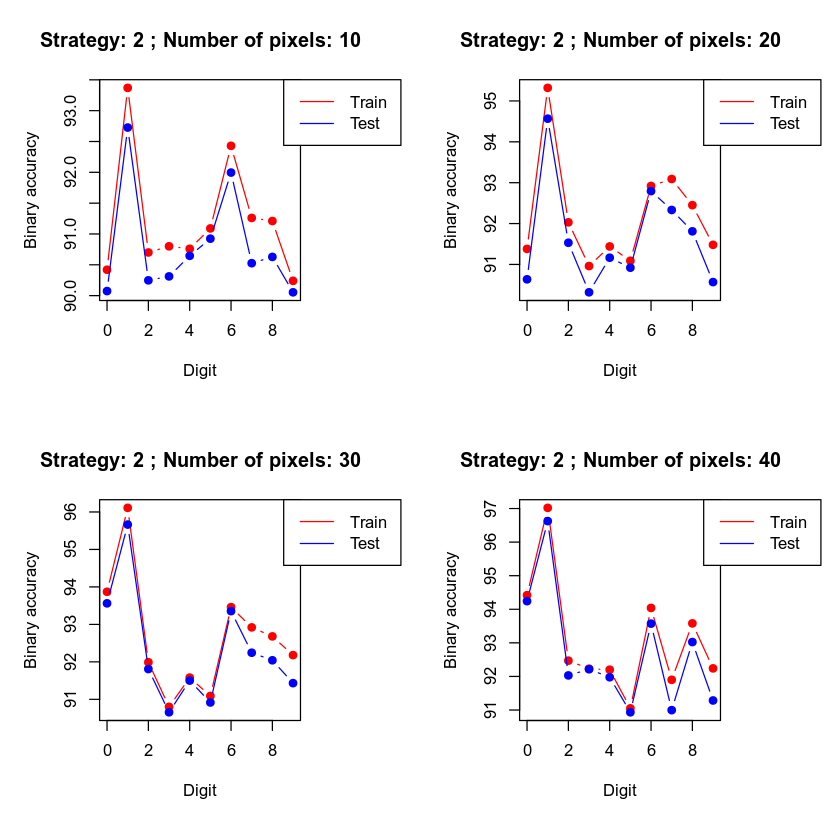

In [45]:
oldw <- getOption("warn")
options(warn = -1)

par(mfrow=c(2, 2))

df.st.2 <- list()
for (n in seq(10, 40, 10)){
    
    df.st.2[[n / 10]] <- strategy.2(n, idx.train, idx.test)
    
    opar <- par(no.readonly = TRUE)
    par(mar = c(6, 5, 4, 6))
    plotter(df.st.2[[n / 10]]$train, df.st.2[[n / 10]]$test, n, 2)
}

options(warn = oldw)

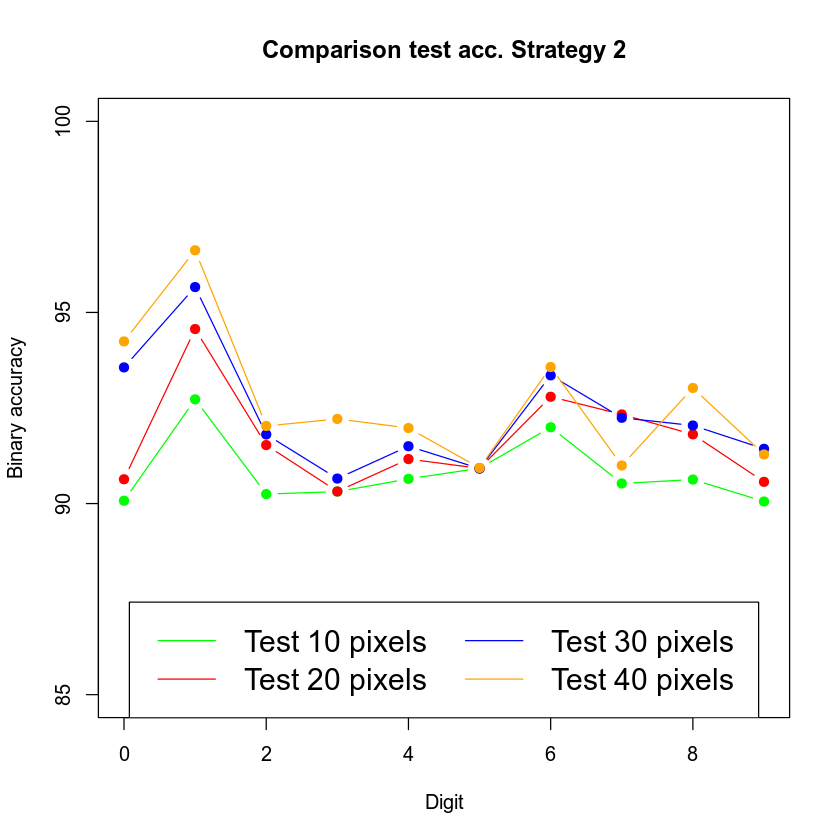

In [46]:
colors = c("green", "red", "blue", "orange")
plot(NULL, xlab = "Digit", ylab = "Binary accuracy",
     xlim = c(0,9), ylim = c(85,100),
     main = "Comparison test acc. Strategy 2")

for (i in 1:length(df.st.2)){
    lines(0:9, df.st.2[[i]]$test, col = colors[i],  pch = 19, type = 'b')
}
legend("bottom", legend = c("Test 10 pixels","Test 20 pixels","Test 30 pixels","Test 40 pixels"),
               lty = 1, col = colors, cex = 1.5, ncol = 2)

Vemos que para 30 y 40 píxeles, los resultados se intercalan. ¿Con cuál nos quedamos? Veamos el error en el train:

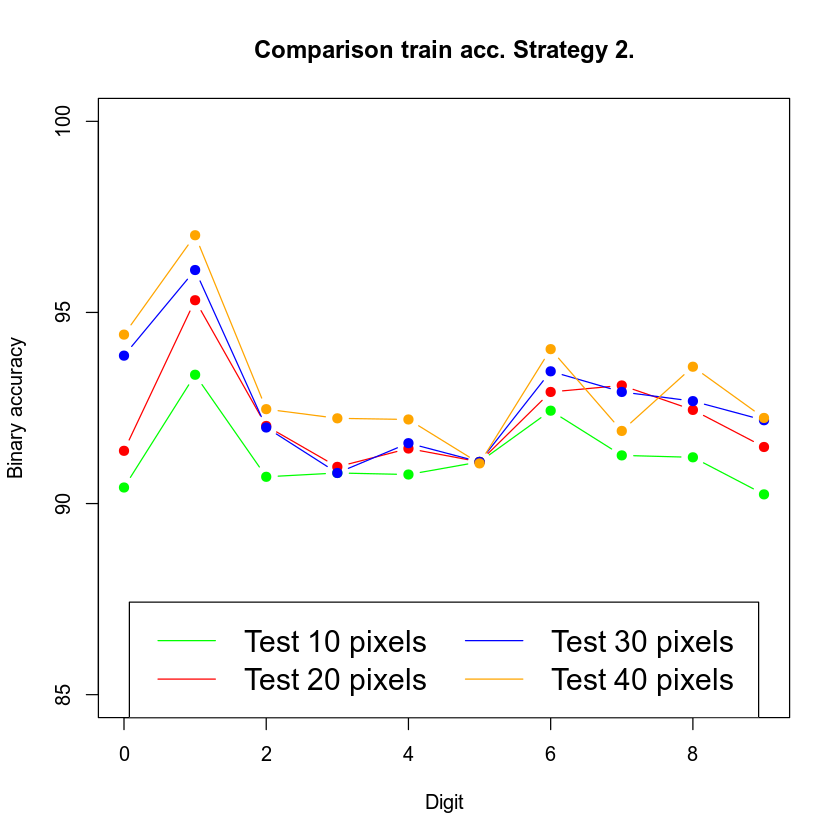

In [47]:
colors = c("green", "red", "blue", "orange")
plot(NULL, xlab = "Digit", ylab = "Binary accuracy",
     xlim = c(0,9), ylim = c(85,100),
     main = "Comparison train acc. Strategy 2.")

for (i in 1:length(df.st.2)){
    lines(0:9, df.st.2[[i]]$train, col = colors[i],  pch = 19, type = 'b')
}
legend("bottom", legend = c("Test 10 pixels","Test 20 pixels","Test 30 pixels","Test 40 pixels"),
               lty = 1, col = colors, cex = 1.5, ncol = 2)

Estamos en la misma situación. Hagamos la media de accuracy sobre test.

El representante será:
* Si index 3, entonces 30 pixeles.
* Si index 4, entonces 40 píxeles.

In [48]:
i.best.2 <- 0
ac.max <- 0
# Yellow line: 4 -> 40 pixels
# Blue line:   3 -> 30 pixels
for (i in c(3,4)){
    if (mean(df.st.2[[i]]$test) > ac.max){
        ac.max <- mean(df.st.2[[i]]$test)
        i.best.2 <- i
    }
}

print(paste("Select index", i.best.2))

[1] "Select index 4"


# Estrategia 3: suma + eliminar márgenes + máximos/mínimos.

En la estrategia anterior, consierábamos 50 imágenes aleatorias que se correspondían con el dígito en estudio y, entendiéndolas como una matriz, hacíamos la media de cada entrada con su adyacentes y considerábamos los $N$ píxeles con más valor que se encontraban en la zona central resultante de eliminar los márgenes.

Seguiremos un punto de vista similar. Esta vez, no haremos la media sino que sumaremos directamente las matrices de las 50 imágenes consideradas. Para la matriz resultante, consideraremos los $N_{max}$ píxeles con mayor valor y los los $N_{min}$ píxeles con menos valor que se encuentren en la zona central.

In [49]:
strategy.3 <- function(n.max, n.min, indexes.train, indexes.test){
    
    #
    # Function for 3rd strategy: remove bounds + adjacent neighbors + N maximum pixels. 
    #
    # @description: Function for 1st strategy: remove bounds and select random pixels.
    #
    # @param n.max: int. Number of desired maximum pixels.
    # @param n.min: int. Number of desired minimum pixels.
    # @param indexes.train: numeric vector. Vector of indexes for training sample.
    # @param indexes.test: numeric vector. Vector of indexes for test sample.
    #
    # @return: dataframe. Dataframe 10x2. First column: accuracy on train. Second column: accuracy in test.
    # Rows 1,...,10 are correspond to digits 0,...,9 resp.
    #
    
    # Empty vetor to store accuracy on train
    acc.train <- c()
    
    # Empty vetor to store accuracy on test
    acc.test <- c()

    # Consider each digit
    for (digit in 0:9){
    
        # Binary vector of labels
        y.digit <- y_train
        y.digit[which(y_train != digit)] <- 0
        y.digit[which(y_train == digit)] <- 1
        
        # Create dataframe
        data.digit <- data.frame(y.digit, x_train)
    
        # Train data
        data.digit.train <- data.digit[indexes.train, ]
        # Test data
        data.digit.test <- data.digit[indexes.test, ]
    
        # For those who truly are the digit we are condidering, select the first 50 images
        # Change 50 for other number if desired
        data.digit.true = subset(data.digit.train,
                                 data.digit.train$y.digit == 1)[sample(nrow(subset(data.digit.train, 
                                                                  data.digit.train$y.digit == 1)),50),]
    
        # Sum pixels for consideres images
        sums <- matrix(rep(0, 28*28), ncol = 28)
            for (n in 1:nrow(data.digit.true)){
                sums <- sums + matrix(as.matrix(data.digit.true[n,-1]), ncol = 28)
            }
    
    
        # Select pixels
        v <- as.numeric(as.list(t(sums)))
        order.v = setdiff(order(v), del)
        max.sel = tail(order.v, n.max) # Maximum pixels inside bounds
        min.sel = head(order.v, n.min) # Minimum pixels inside bounds
        j <- c(max.sel, min.sel)  
    
        # logistic regression
        model.digit <- glm(data.digit.train$y.digit~.,
                           data = data.digit.train[, j],
                           family = binomial(link = "logit"))
    
        # Analysis for train data
        out.train <- model.digit$fitted.values
        out.bin.train <- as.double(out.train > 0.5)
        acc.digit.train <- 100*sum(diag(table(data.digit.train[,1], out.bin.train))) / length(out.bin.train)
        acc.train <- c(acc.train, acc.digit.train)
        #cat(sprintf("Binary accuracy for digit %s on training data: %s \n", digit, acc.digit.train))
    
        # Analysis for test data
        out.test <- predict(object = model.digit, newdata = data.digit.test[,j]);
        out.bin.test <- as.double(out.test > 0.5)
        acc.digit.test <- 100*sum(diag(table(data.digit.test[,1], out.bin.test))) / length(out.bin.test)
        acc.test <- c(acc.test, acc.digit.test)
        #cat(sprintf("Binary accuracy for digit %s on test data: %s \n", digit, acc.digit.test))
        #cat("\n")
    }
    
    return(data.frame(train = acc.train, test = acc.test))
}



[[1]]
[1] 2

[[2]]
[1] 3

[[3]]
[1] 4

[[4]]
[1] 5

[[5]]
[1] 6

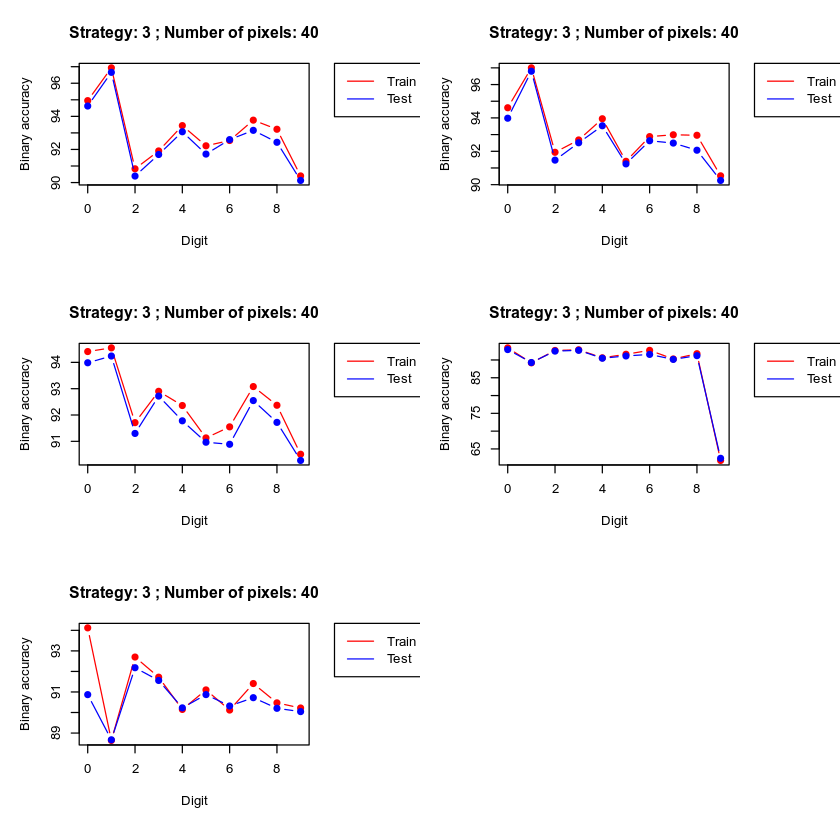

In [50]:
oldw <- getOption("warn")
options(warn = -1)

df.st.3 <- list()
i <- 1

par(mfrow=c(3,2))

foreach (nmax = rev(seq(0,40,10)), nmin = seq(0,40,10)) %dopar% {
        
    # Apply strategy 3
    df.st.3[[i]] <- strategy.3(nmax, nmin, idx.train, idx.test)
    
    # Plot resluts
    opar <- par(no.readonly = TRUE)
    par(mar = c(6, 5, 4, 7))
    plotter(df.st.3[[i]]$train, df.st.3[[i]]$test, nmax + nmin, 3)
    
    i <- i + 1
}
    
options(warn = oldw)

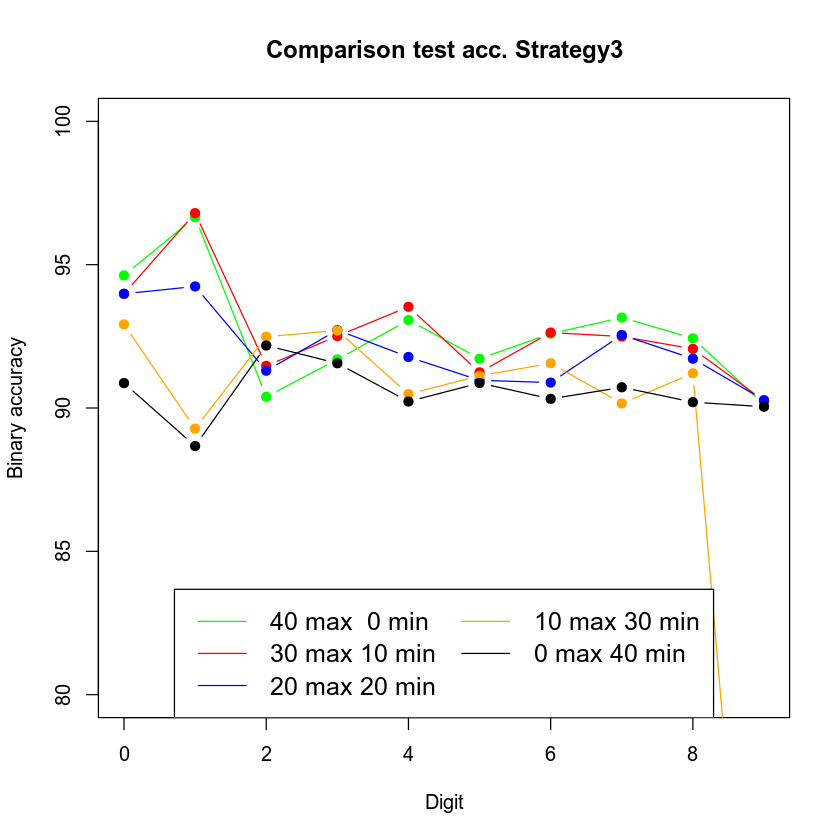

In [51]:
colors = c("green", "red", "blue", "orange", "black")
plot(NULL, xlab = "Digit", ylab = "Binary accuracy",
     xlim = c(0,9), ylim = c(80,100),
     main = "Comparison test acc. Strategy3")

for (i in 1:length(df.st.3)){
    lines(0:9, df.st.3[[i]]$test, col = colors[i],  pch = 19, type = 'b')
}
legend("bottom", lty = 1, col = colors, cex = 1.25, ncol = 2,
       legend = c("40 max  0 min", "30 max 10 min", "20 max 20 min", "10 max 30 min", "0 max 40 min"),)

Parece que los píxeles realmente significativos son aquellos que están coloreados, es decir, que contienen un valor más alto. Veamos que ocurre sobre el train para tener un mejor criterio:

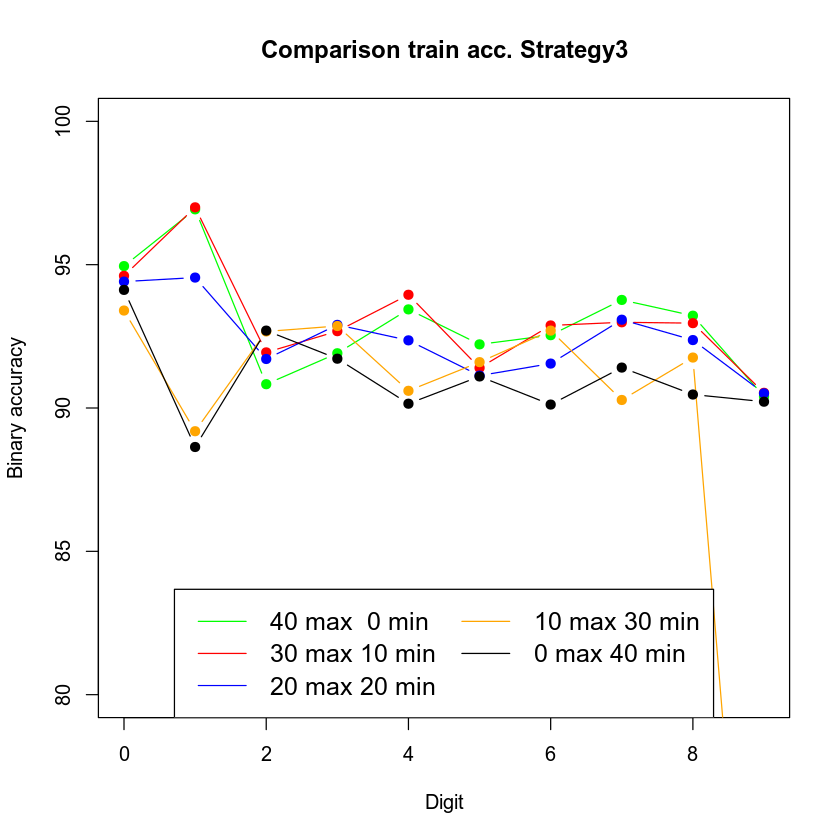

In [52]:
plot(NULL, xlab = "Digit", ylab = "Binary accuracy",
     xlim = c(0,9), ylim = c(80,100),
     main = "Comparison train acc. Strategy3")

for (i in 1:length(df.st.3)){
    lines(0:9, df.st.3[[i]]$train, col = colors[i],  pch = 19, type = 'b')
}
legend("bottom", lty = 1, col = colors, cex = 1.25, ncol = 2,
       legend = c("40 max  0 min", "30 max 10 min", "20 max 20 min", "10 max 30 min", "0 max 40 min"),)

Parece que la linea más adecuada es la verde, pero la azul y la roja tampoco son despreciables. Hagamos la media sobre el test:
* Si index = 1, entonces el representante es 40 máximos y 0 mínimos.
* Si index = 2, entonces el representante es 30 máximos y 10 mínimos.
* Si index = 3, entonces el representante es 20 máximos y 20 mínimos.

In [53]:
i.best.3 <- 0
ac.max <- 0
for (i in c(1,2,3)){
    if (mean(df.st.3[[i]]$test) > ac.max){
        ac.max <- mean(df.st.3[[i]]$test)
        i.best.3 <- i
    }
}

print(paste("Select index", i.best.3))

[1] "Select index 2"


# Comparación estrategias para selección

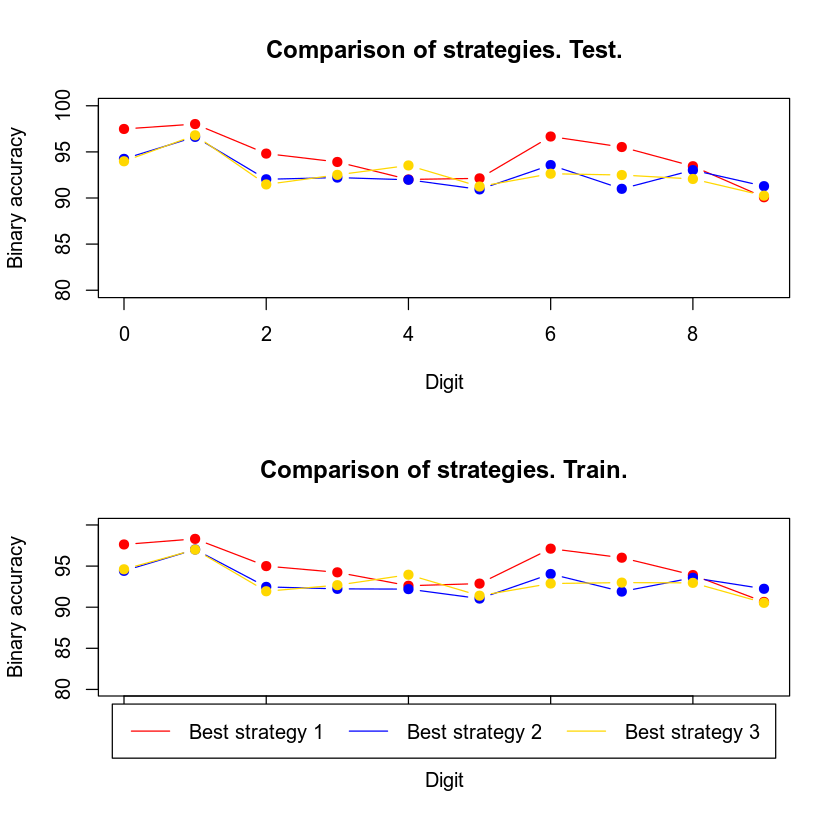

In [54]:
par(mfrow=c(2,1),xpd=NA)


plot(NULL, xlab = "Digit", ylab = "Binary accuracy",
     xlim = c(0,9), ylim = c(80,100),
     main = "Comparison of strategies. Test.")

lines(0:9, df.st.1[[4]]$test, col = "red",  pch = 19, type = 'b')
lines(0:9, df.st.2[[i.best.2]]$test, col = "blue", pch = 19, type = 'b')
lines(0:9, df.st.3[[i.best.3]]$test, col = "gold", pch = 19, type = 'b')

opar <- par(no.readonly = TRUE)
par(mar = c(6, 4.1, 4.1, 2.1))


plot(NULL, xlab = "Digit", ylab = "Binary accuracy",
     xlim = c(0,9), ylim = c(80,100), 
     main = "Comparison of strategies. Train.")


lines(0:9, df.st.1[[4]]$train, col = "red",  pch = 19, type = 'b')
lines(0:9, df.st.2[[i.best.2]]$train, col = "blue", pch = 19, type = 'b')
lines(0:9, df.st.3[[i.best.3]]$train, col = "gold", pch = 19, type = 'b')

legend("bottom", ncol = 3, lty = 1, col = c("red", "blue", "gold"), inset = c(0, -0.35),
       legend = c("Best strategy 1", "Best strategy 2", "Best strategy 3"))


Nos quedamos con la primera estrategia: selección de 40 píxeles aleatorios tras elminar márgenes. Hemos de tener en cuenta la aleatoriedad.

Seleccionamos el representante de cada estrategia. **Ordenamos su accuracy en el test desde el mdígito que mejor clasifica hasta el peor**:
(Restamos 1 ya que los dítitos empiezna en 0 y no en 1 como sí empiezan los índices en R:

**Ranking estrategia 1:**

In [55]:
order(df.st.1[[4]]$test, decreasing = T) - 1

[1] 1 0 6 7 2 3 8 5 4 9

In [56]:
sort(df.st.1[[4]]$test, decreasing = T)

[1] 98.018 97.486 96.668 95.528 94.816 93.908 93.446 92.130 92.012 90.082

**Ranking estrategia 2:**

In [57]:
order(df.st.2[[i.best.2]]$test, decreasing = T) - 1

[1] 1 0 6 8 3 2 4 9 7 5

In [58]:
sort(df.st.2[[i.best.2]]$test, decreasing = T)

[1] 96.626 94.242 93.572 93.024 92.214 92.030 91.976 91.284 90.996 90.932

**Ranking estrategia 3:**

In [59]:
order(df.st.3[[i.best.3]]$test, decreasing = T) - 1

[1] 1 0 4 6 3 7 8 2 5 9

In [60]:
sort(df.st.3[[i.best.3]]$test, decreasing = T)

[1] 96.798 93.982 93.530 92.632 92.510 92.492 92.064 91.470 91.244 90.252

Observamos que el 1 es el dígito que mejor clasifica y el 9 el que peor lo hace. Es causa de la grafía de los propios dígitos. 

<font color='blue'>***PRACTICA 2: Tener en cuenta la variabilidad del error de test a la hora de construir el ranking anterior. Para ello, además de calcular la tasa de acierto para cada dígito, considerar también un "intervalo de confianza" obtenido como la dispersión (desviación típica) de 10 medidas de test obtenidas con 10 muestras aleatorias distintas. ¿Existe algún dígito que pueda predecirse significativamente mejor que los demás?***</font>

Seleccionaos la estrategia 1. **Estamos entrenando 10x10 modelos:**

In [61]:
oldw <- getOption("warn")
options(warn = -1)

df.best <- list()
for (id.sample in 1:10){
    idx.sample.train <- sample(x = 1:nrow(x_train), size = 10000,  replace = F)
    idx.sample.test <- setdiff(x = 1:nrow(x_train), y = idx.sample.train)
    idx.id.sample <- sample(pixels.centre, 40, replace = F)
    df.best[[id.sample]] <- strategy.1(idx.id.sample, idx.sample.train, idx.sample.test)
}


options(warn = oldw)

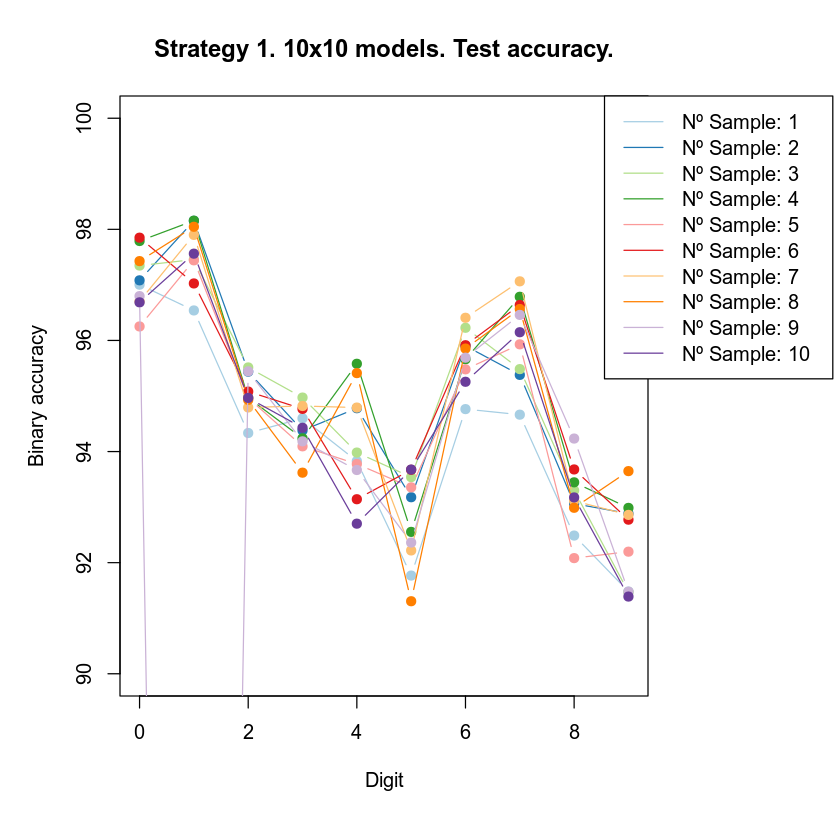

In [62]:
colors = brewer.pal(10, "Paired")
opar <- par(no.readonly = TRUE)
par(mar = c(6, 5, 4, 8))
plot(NULL, xlab = "Digit", ylab = "Binary accuracy",
     xlim = c(0, 9), ylim = c(90,100), main = "Strategy 1. 10x10 models. Test accuracy.")

for (i in 1:length(df.best)){
    lines(0:9, df.best[[i]]$test, col = colors[i],  pch = 19, type = 'b')
}


legend("topright",  inset = c(-0.35, 0), ncol = 1, lty = 1,
       legend = paste0('Nº Sample: ', 1:10) , col = colors[1:length(df.best)], xpd = T)
on.exit(par(opar))

In [63]:
df.best.tests <- data.matrix(bind_cols(df.best))[,seq(2,20,2)]

New names:
* train -> train...1
* test -> test...2
* train -> train...3
* test -> test...4
* train -> train...5
* ...



Nos dice que está renombrando columnas pero no nos importa, sabemos cómo están ordenados: el volumen de datos es pequeño.

In [64]:
df.best.tests

test...2 test...4 test...6 test...8 test...10 test...12 test...14
 [1,] 97.004   97.082   97.348   97.790   96.252    97.850    96.706   
 [2,] 96.540   98.154   97.456   98.156   97.442    97.026    97.900   
 [3,] 94.334   95.438   95.514   94.968   94.964    95.080    94.794   
 [4,] 94.598   94.380   94.972   94.238   94.094    94.768    94.820   
 [5,] 93.828   94.780   93.982   95.580   93.776    93.142    94.792   
 [6,] 91.768   93.178   93.540   92.554   93.356    93.672    92.220   
 [7,] 94.764   95.902   96.228   95.662   95.480    95.914    96.408   
 [8,] 94.664   95.380   95.484   96.786   95.930    96.638    97.064   
 [9,] 92.488   93.062   93.300   93.446   92.082    93.678    93.112   
[10,] 91.480   92.884   91.468   92.986   92.198    92.774    92.860   
      test...16 test...18 test...20
 [1,] 97.428    96.798    96.686   
 [2,] 98.046    39.986    97.562   
 [3,] 94.930    95.444    94.966   
 [4,] 93.620    94.184    94.428   
 [5,] 95.412    93.668    92.702   
 [6,] 91.306    92.362    93.676   
 [7,] 95.854    95.690    95.256   
 [8,] 96.566    96.460    96.148   
 [9,] 92.988    94.234    93.174   
[10,] 93.648    91.478    91.390

In [65]:
df.best.tests.mean.row <- rowMeans(df.best.tests)
df.best.tests.mean.row

[1] 97.0944 91.8268 95.0432 94.4102 94.1662 92.7632 95.7158 96.1120 93.1564
[10] 92.3166

In [66]:
df.best.tests.sd.row <- apply(df.best.tests, 1, sd)
df.best.tests.sd.row

[1]  0.5114092 18.2223300  0.3551653  0.4018418  0.9463884  0.8432515
 [7]  0.4727042  0.7472771  0.5942710  0.8194231

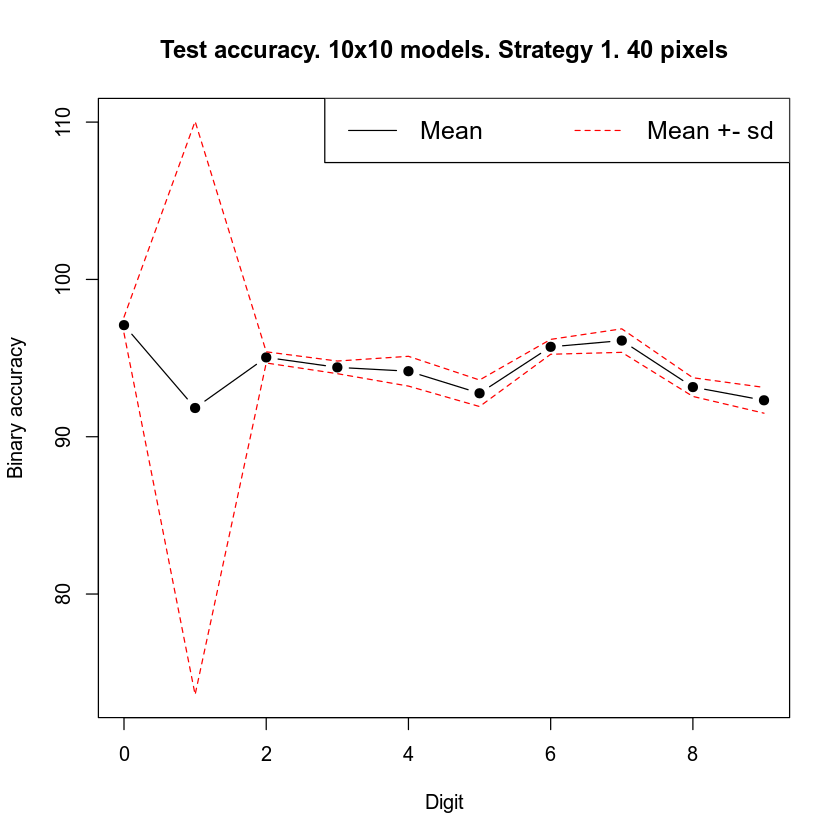

In [67]:
plot(0:9, df.best.tests.mean.row, pch = 19, type = "b",
    ylim = c(min(df.best.tests.mean.row - df.best.tests.sd.row),
             max(df.best.tests.mean.row + df.best.tests.sd.row)),
    main = "Test accuracy. 10x10 models. Strategy 1. 40 pixels",
    ylab = "Binary accuracy",
    xlab = "Digit")

lines(0:9, df.best.tests.mean.row - df.best.tests.sd.row, lty = 2, col = "red")
lines(0:9, df.best.tests.mean.row + df.best.tests.sd.row, lty = 2, col = "red")

legend("topright", ncol = 2, lty = c(1,2), cex = 1.25,
       legend = c("Mean", "Mean +- sd"), col = c("black", "red"))

Repetimos el ranking:

In [68]:
order(df.best.tests.mean.row, decreasing = T) - 1

[1] 0 7 6 2 3 4 8 5 9 1

Observamos, al igual que en las anteriores gráficas, que el 1 se clasifica bastante mejor que el resto. Quizá pueda deberse a su propia naturaleza. La mayoría de la spersonas escriben el 1 como un segmento, de modo que sólo ocupará ciertas columnas en la matriz de la imagen o, si está inclinado, cierta diagonal. Además, las diagonales siempre irán en el mismp sentido (no creo que mucha gente escriba el 1 inclinado empezando arriba a la izquiera y acabando abajo a la derecha).

**En clase se ha sigerido que, dado un modelo para cada dígito (10 modelos en total), se dividea la parte del test en 10 trozos y se haga una predicción en cada uno de ellos. Lo hacemos con la estrategia 1.**

In [69]:
index.train <- sample(x = 1:nrow(x_train), size = 10000,  replace = F)
index.test <- setdiff(x = 1:nrow(x_train), y = index.train)
index.sample <- sample(pixels.centre, 40, replace = F)

acc.list <- c()

for (d in 0:9){
    
    y.d <- y_train
    y.d[which(y_train != d)] <- 0
    y.d[which(y_train == d)] <- 1
    
    digit.d <- data.frame(my.d = y.d, x_train)
    digit.train.d <- digit.d[index.train, ]
    digit.test.d <- digit.d[index.test, ]
    
    model.d <- glm(digit.train.d$my.d ~ ., data = digit.train.d[, index.sample],
                   family = binomial(link = "logit"))
    
    for (j in 1:10){
        pred.d <- predict(object = model.d, newdata = digit.test.d[(5000*(j-1) +1):(5000*j), index.sample])
        pred.d.bin <- as.double(pred.d > 0.5)
        
        acc.d <- 100*sum(diag(table(digit.test.d[(5000*(j-1) +1):(5000*j), 1], pred.d.bin)))/length(pred.d.bin)
        acc.list <- c(acc.list, acc.d)
    }
    
        
}


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Cada columna corresponde a un dígito: la columna 1 corresponde al dígito 0; la columna 2 corresponde al dígito 1...

In [70]:
mat.10.10 <- matrix(acc.list, ncol = 10)
mat.10.10

[,1]  [,2]  [,3]  [,4]  [,5]  [,6]  [,7]  [,8]  [,9]  [,10]
 [1,] 96.84 98.00 95.40 95.24 94.60 93.54 96.26 96.52 94.38 91.12
 [2,] 96.22 98.02 95.52 95.00 95.20 93.02 96.40 95.94 93.82 91.58
 [3,] 96.30 98.14 94.82 93.72 94.78 93.56 95.94 96.58 93.02 90.60
 [4,] 96.58 98.34 94.96 95.32 94.64 93.64 95.84 97.24 94.36 90.98
 [5,] 96.18 98.12 94.70 94.84 94.84 93.48 96.02 96.30 93.46 91.52
 [6,] 96.46 98.34 95.24 94.50 94.62 93.84 95.54 95.74 92.90 90.44
 [7,] 96.16 98.22 95.24 94.96 93.90 93.14 96.42 96.30 93.92 91.68
 [8,] 95.74 98.32 95.16 94.62 94.96 93.46 96.34 95.96 93.22 91.48
 [9,] 96.30 98.40 95.26 94.66 95.12 93.40 95.84 96.40 93.66 91.46
[10,] 96.78 98.26 95.86 95.18 95.56 93.48 97.18 96.80 94.70 91.66

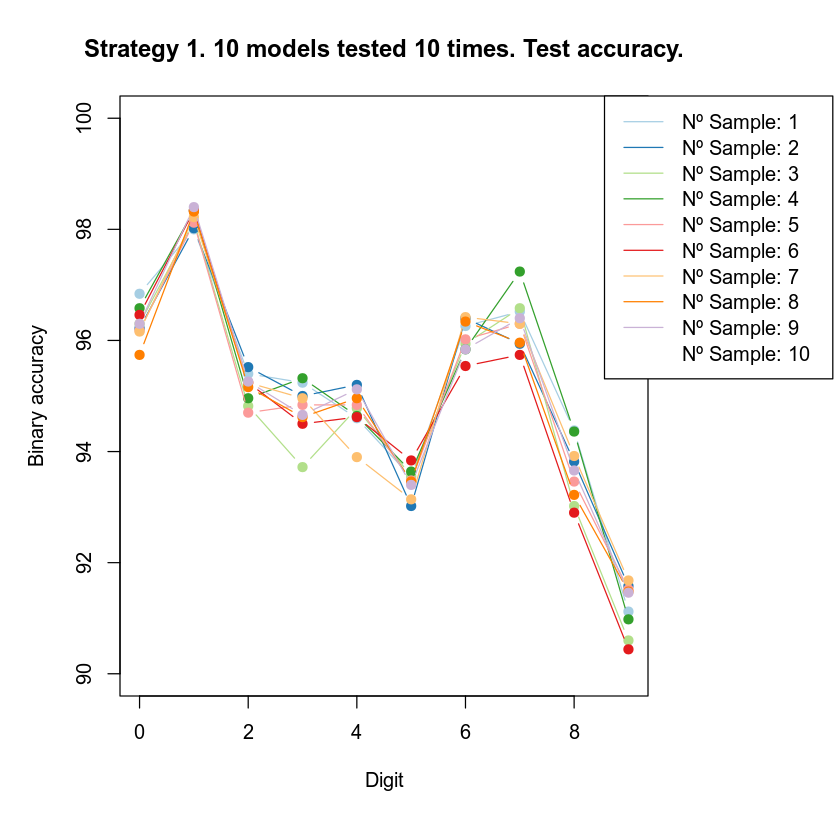

In [71]:
colors = brewer.pal(9, "Paired")
opar <- par(no.readonly = TRUE)
par(mar = c(6, 5, 4, 8))
plot(NULL, xlab = "Digit", ylab = "Binary accuracy",
     xlim = c(0, 9), ylim = c(90,100), main = "Strategy 1. 10 models tested 10 times. Test accuracy.")

for (i in 1:nrow(mat.10.10)){
    lines(0:9, mat.10.10[i,], col = colors[i],  pch = 19, type = 'b')
}


legend("topright",  inset = c(-0.35, 0), ncol = 1, lty = 1,
       legend = paste0('Nº Sample: ', 1:10) , col = colors[1:nrow(mat.10.10)], xpd = T)
on.exit(par(opar))

Calculamos la media por columnas:

In [72]:
mat.10.10.means <- apply(mat.10.10, 2, mean)
mat.10.10.means

[1] 96.356 98.216 95.216 94.804 94.822 93.456 96.178 96.378 93.744 91.252

Calculamos la desviación típica por columnas:

In [73]:
mat.10.10.sd <- apply(mat.10.10, 2, sd)
mat.10.10.sd

[1] 0.3246605 0.1404121 0.3392541 0.4694962 0.4435664 0.2341509 0.4548455
 [8] 0.4432657 0.6085904 0.4472335

Graficamos el intervalo de confianza:

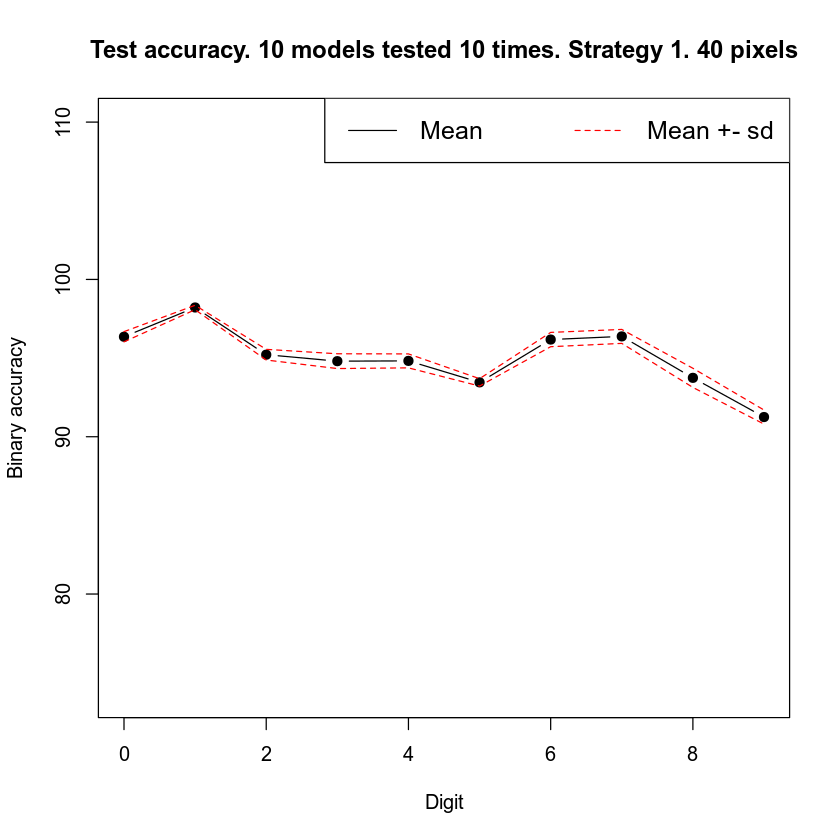

In [74]:
plot(0:9, mat.10.10.means, pch = 19, type = "b",
    ylim = c(min(df.best.tests.mean.row - df.best.tests.sd.row),
             max(df.best.tests.mean.row + df.best.tests.sd.row)),
    main = "Test accuracy. 10 models tested 10 times. Strategy 1. 40 pixels",
    ylab = "Binary accuracy",
    xlab = "Digit")

lines(0:9, mat.10.10.means - mat.10.10.sd, lty = 2, col = "red")
lines(0:9, mat.10.10.means + mat.10.10.sd, lty = 2, col = "red")

legend("topright", ncol = 2, lty = c(1,2), cex = 1.25,
       legend = c("Mean", "Mean +- sd"), col = c("black", "red"))

Obtenemos el ranking:

In [75]:
order(mat.10.10.means, decreasing = T) - 1

[1] 1 7 0 6 2 4 3 8 5 9

<font color='blue'>***TRABAJO EXTRA: Hasta ahora hemos utilizado la tasa de acierto como medida de validación de los clasificadores. Para ello, las predicciones probabilísticas se tiene que convertir a binarias (utilizando un umbral para al probabilidad). Sin embargo, existen otras medidas más generales que consideran el carácter probabilístico de la predicción.  https://es.wikipedia.org/wiki/Curva_ROC***</font> 
    
#roc<-roc(out,as.factor(datT[,1]))
#auc(roc)
#plot(roc)

Emplearemos la estrategia 2, por cambiar.

In [76]:
strategy.2.roc <- function(N, indexes.train, indexes.test, n.digit){

    # Same as strategy.2 function but returning roc curves
    
    # Binary labels
    y.digit <- y_train
    y.digit[which(y_train != n.digit)] <- 0
    y.digit[which(y_train == n.digit)] <- 1
    
    # Dataframe
    data.digit <- data.frame(y.digit, x_train)
    data.digit.train <- data.digit[indexes.train, ]
    data.digit.test <- data.digit[indexes.test, ]
    data.digit.true = subset(data.digit.train, y.digit == 1)[sample(nrow(subset(data.digit.train,
                            y.digit == 1)), 50, replace = F), ]
        
    # Strategy2: mean adjacent neighbors
    sum <- matrix(rep(0, 28 * 28), ncol = 28)
    for (n in 1:nrow(data.digit.true)) {
        sum <- sum + avg.neighbors(matrix(as.matrix(data.digit.true[n, -1]), ncol = 28))
    }
    
    # MAximum central pixels
    j <- setdiff(order(as.numeric(as.list(t(sum))), decreasing = T), del)
    j <- j[1:N]
    
    # Logistic regression
    model.digit <- glm(data.digit.train$y.digit ~ ., data = data.digit.train[, j],
                       family = binomial(link = "logit"))
    
    # Performance on train
    out.train <- model.digit$fitted.values
    out.bin.train <- as.double(out.train > 0.5)
    acc.digit.train <- 100 * sum(diag(table(data.digit.train[, 1], out.bin.train)))/length(out.bin.train)
    #acc.train <- c(acc.train, acc.digit.train)
    
    # Performance on test
    out.test <- predict(object = model.digit, newdata = data.digit.test[, j])
    out.bin.test <- as.double(out.test > 0.5)
    acc.digit.test <- 100 * sum(diag(table(data.digit.test[, 1], out.bin.test)))/length(out.bin.test)
    #acc.test <- c(acc.test, acc.digit.test)
        
    # ROC curve on test
    cat(bold(red(paste0("Confusion matrix for ", N, " pixels and digit ", n.digit, "."))))
    cat("\n")
    conf_mat <- table(data.digit.test[, 1], out.bin.test)
    print(conf_mat)
    print(paste("Binary accuracy on test: ", acc.digit.test))
    
    if (sum(dim(conf_mat)) == 4) {
        
        # Confusion matrix entries
        tp <- conf_mat[1,1]   # True  positive
        fp <- conf_mat[1,2]   # False positive
        fn <- conf_mat[2,1]   # False negative
        tn <- conf_mat[2,2]   # True  negative
        
        # Calculate rates
        tpr <- tp / (tp + fn) # True  positive rate
        tnr <- tn / (fp + tn) # True  negative rate
        fpr <- fp / (fp + tn) # False positive rate
        fnr <- fn / (tp + fn) # False negative rate
    
        # Display results
        cat("\n")
        print(sprintf("True  Positive Rate %f", tpr))
        print(sprintf("True  Negative Rate %f", tnr)) 
        print(sprintf("False Positive Rate %f", fpr)) 
        print(sprintf("False Negative Rate %f", fnr))
        cat("\n")
        
        }
    
    roc <- roc(out.test, as.factor(data.digit.test[, 1]))
    print(paste("AUC non binary: ", auc(roc)))
    cat("\n")
    
    roc.bin <- roc(out.bin.test, as.factor(data.digit.test[, 1]))
    print(paste("AUC binary output: ", auc(roc.bin)))
    cat("\n")
 
    l <- list("roc.1" = roc, "roc.2" = roc.bin)
    
    
    return(l)
}

Realizaremos este apartado empleando la estrategia 2.

In [77]:
idx.aux.train <- sample(x = 1:nrow(x_train), size = 10000,  replace = F)
idx.aux.test <- setdiff(x = 1:nrow(x_train), y = idx.aux.train)

**Fijamos dígito y cambiamos pixeles:**

In [78]:
oldw <- getOption("warn")
options(warn = -1)

pixels <- c(10, 25, 50, 75, 100) # Cange if desired
l.pix <- list()
my_digit <- 1 # Change if desired
i <- 1

for (pix in pixels){
    res <- strategy.2.roc(pix, idx.aux.train, idx.aux.test, my_digit)
    l.pix[[i]] <- res
    i <- i+1
}

options(warn = oldw) 

Confusion matrix for 10 pixels and digit 1.
   out.bin.test
        0     1
  0 43587   754
  1  2672  2987
[1] "Binary accuracy on test:  93.148"

[1] "True  Positive Rate 0.942238"
[1] "True  Negative Rate 0.798450"
[1] "False Positive Rate 0.201550"
[1] "False Negative Rate 0.057762"

[1] "AUC non binary:  0.963299238369479"

[1] "AUC binary output:  0.755413597121146"

Confusion matrix for 25 pixels and digit 1.
   out.bin.test
        0     1
  0 43681   660
  1  1740  3919
[1] "Binary accuracy on test:  95.2"

[1] "True  Positive Rate 0.961692"
[1] "True  Negative Rate 0.855864"
[1] "False Positive Rate 0.144136"
[1] "False Negative Rate 0.038308"

[1] "AUC non binary:  0.975186475405068"

[1] "AUC binary output:  0.838820268559238"

Confusion matrix for 50 pixels and digit 1.
   out.bin.test
        0     1
  0 43788   553
  1  1089  4570
[1] "Binary accuracy on test:  96.716"

[1] "True  Positive Rate 0.975734"
[1] "True  Negative Rate 0.892055"
[1] "False Positive Rate 0.10794

Dibujamos las curvas ROC:

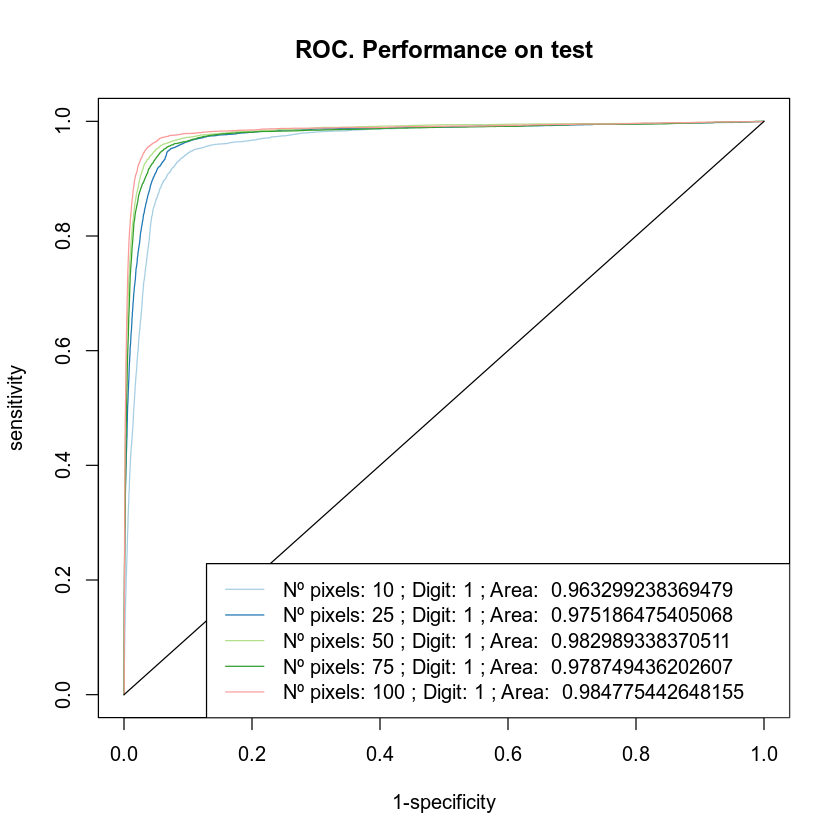

In [79]:
colors = brewer.pal(9, "Paired")
aucs <- c()

plot(NULL, xlab = "1-specificity", ylab = "sensitivity", main = "ROC. Performance on test",
     xlim = c(0,1), ylim = c(0, 1))

for (i in 1:length(l.pix)){
    plot(l.pix[[i]]$roc.1, col = colors[i], add = T)
    aucs <- c(aucs, auc(l.pix[[i]]$roc.1))
    
}


lines(c(0,1), c(0,1), type = "l")

legend("bottomright", legend =  paste("Nº pixels:", pixels, "; Digit:", my_digit,"; Area: ", aucs),
        lty = 1, col = colors[1:length(l.pix)], cex = 1.)

Ya vimos que el 1 era el que mejor clasificaba, por ello el área bajo la curva es tal.

**Para pixeles fijos, cambiamos el dígito**

In [80]:
oldw <- getOption("warn")
options(warn = -1)

digits <- seq(0, 9, 2) # Change if desired
my_pixels <- 75 # Change if desired

l.dig <- list()
i <- 1

for (d in digits){
    res <- strategy.2.roc(my_pixels, idx.aux.train, idx.aux.test, d)
    l.dig[[i]] <- res
    i <- i+1
}

options(warn = oldw) 

Confusion matrix for 75 pixels and digit 0.
   out.bin.test
        0     1
  0 43879  1215
  1  1850  3056
[1] "Binary accuracy on test:  93.87"

[1] "True  Positive Rate 0.959544"
[1] "True  Negative Rate 0.715523"
[1] "False Positive Rate 0.284477"
[1] "False Negative Rate 0.040456"

[1] "AUC non binary:  0.924628778791764"

[1] "AUC binary output:  0.797983501998841"

Confusion matrix for 75 pixels and digit 2.
   out.bin.test
        0     1
  0 44662   353
  1  3346  1639
[1] "Binary accuracy on test:  92.602"

[1] "True  Positive Rate 0.930303"
[1] "True  Negative Rate 0.822791"
[1] "False Positive Rate 0.177209"
[1] "False Negative Rate 0.069697"

[1] "AUC non binary:  0.892988756338967"

[1] "AUC binary output:  0.660472264288144"

Confusion matrix for 75 pixels and digit 4.
   out.bin.test
        0     1
  0 44622   512
  1  3014  1852
[1] "Binary accuracy on test:  92.948"

[1] "True  Positive Rate 0.936729"
[1] "True  Negative Rate 0.783418"
[1] "False Positive Rate 0.2165

Dibujamos curvas ROC:

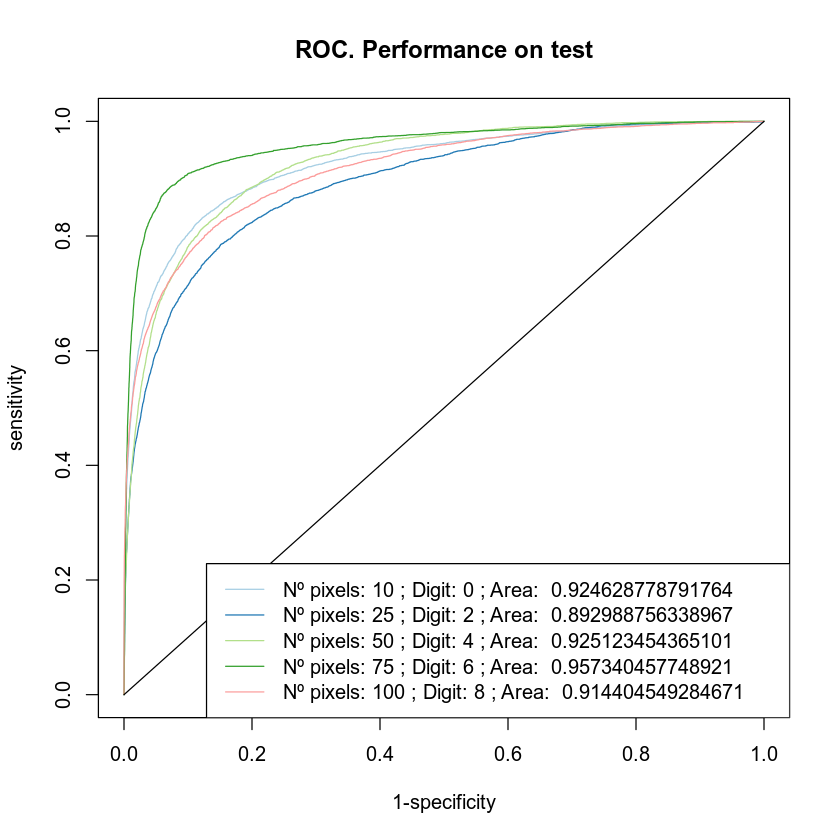

In [81]:
aucs <- c()

plot(NULL, xlab = "1-specificity", ylab = "sensitivity", main = "ROC. Performance on test",
     xlim = c(0,1), ylim = c(0, 1))

for (i in 1:length(l.dig)){
    plot(l.dig[[i]]$roc.1, col = colors[i], add = T)
    aucs <- c(aucs, auc(l.dig[[i]]$roc.1))
}

lines(c(0,1), c(0,1), type = "l")
legend("bottomright", legend =  paste("Nº pixels:", pixels, "; Digit:", digits,"; Area: ", aucs),
        lty = 1, col = colors[1:length(l.pix)], cex = 1)

Comparemos 1 (el que mejor clasificaba) con el 9 que el el que peor clasifica:

In [82]:
oldw <- getOption("warn")
options(warn = -1)

digits <- c(1,9) # Change if desired
my_pixels <- 75 # Change if desired

l.dig <- list()
i <- 1

for (d in digits){
    res <- strategy.2.roc(my_pixels, idx.aux.train, idx.aux.test, d)
    l.dig[[i]] <- res
    i <- i+1
}

options(warn = oldw) 

Confusion matrix for 75 pixels and digit 1.
   out.bin.test
        0     1
  0 43849   492
  1  1200  4459
[1] "Binary accuracy on test:  96.616"

[1] "True  Positive Rate 0.973362"
[1] "True  Negative Rate 0.900626"
[1] "False Positive Rate 0.099374"
[1] "False Negative Rate 0.026638"

[1] "AUC non binary:  0.980565413862607"

[1] "AUC binary output:  0.888426287621796"

Confusion matrix for 75 pixels and digit 9.
   out.bin.test
        0     1
  0 44937   117
  1  4152   794
[1] "Binary accuracy on test:  91.462"

[1] "True  Positive Rate 0.915419"
[1] "True  Negative Rate 0.871570"
[1] "False Positive Rate 0.128430"
[1] "False Negative Rate 0.084581"

[1] "AUC non binary:  0.929986406571183"

[1] "AUC binary output:  0.578968440459399"



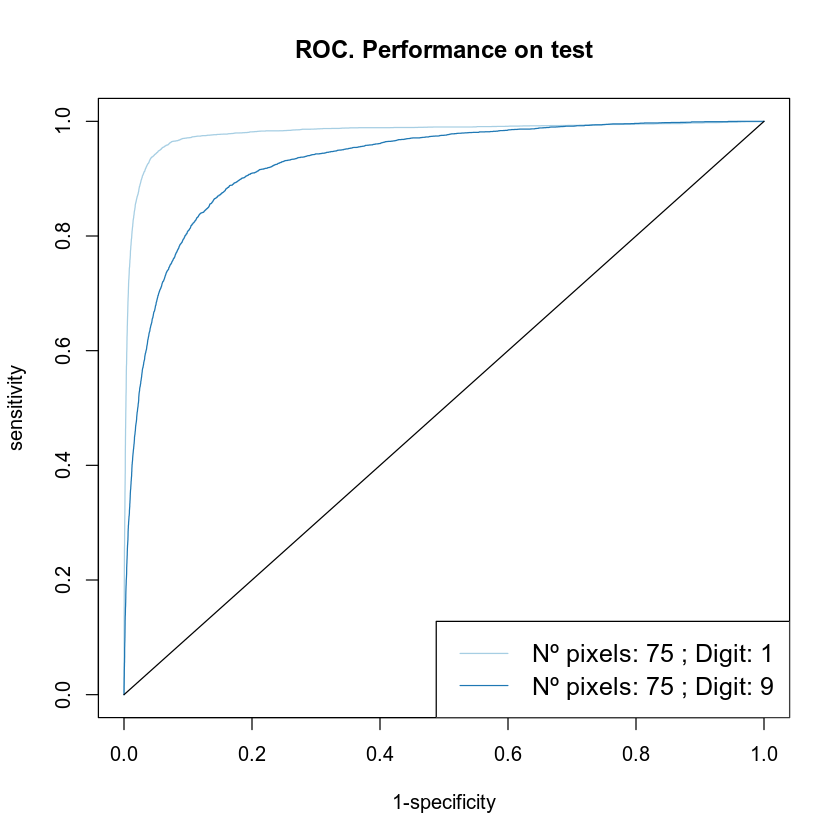

In [83]:
plot(NULL, xlab = "1-specificity", ylab = "sensitivity", main = "ROC. Performance on test",
     xlim = c(0,1), ylim = c(0, 1))

for (i in 1:length(l.dig)){
    plot(l.dig[[i]]$roc.1, col = colors[i], add = T)
}

lines(c(0,1), c(0,1), type = "l")
legend("bottomright", legend =  paste("Nº pixels:", my_pixels, "; Digit:", digits),
        lty = 1, col = colors[1:length(l.pix)], cex = 1.25)

## Interpretación de las tablas de contingencia.

Las tablas de contingencia tienen 4 entradas. Si las interpretamos como una matriz, los elementos se correspinden con:
* Fila 1, columna 1: TRUE POSITIVES
* Fila 1, columna 2: FALSE POSITIVES
* Fila 2, columna 1: FALSE NEGATIVES
* Fila 2, columna 2: TRUE NEGATIVES

La primera fila (POSITIVE) son aquellos elementos que han sido clasificados como positivos. 

La segunda fila (NEGATIVE) son aquellos elementos que han sido clasificados como negativos.

Por otro lado, la primera columna (POSITIVE) son los que realmente son positivos.

La primera columna (NEGATIVE) son los que realmente son negativos.

Por tanto, los verdaderos positivos son aquellos elementos que realmente son positivos y que han sido clasificados positivos. 

Los falsos positivos son los elementos que han sido clasificados como positivos pero que en realidad son negativos. 

Los verdaderos negativos son aquellos elementos que realmente son negativos y que han sido clasificados negativos. 

Los falsos negativos son los elementos que han sido clasificados como negativos pero que en realidad son positivos. 

Es por ello que al calcular el accuracy nos quedamos con la diagonal, pues continen los elementos que han sido correctamente clasificados. 


En nuestro caso, NEGATIVE se corresponde con 1; POSITIVE se corresponde con 0.

## Interpretación de las curvas ROC y áreas bajo la curva AUC.


Una curva ROC consiste en graficar el TRUE POSITIVE RATE (conocido como Sensitivity) en función del FALSE POSITIVE RATE (conocido como 1-specificity) para diferentes puntos de corte (cut-offs). Cada punto de la curca representa un par (sensitivity, 1-specificity) correspondiente a cierto umbral de decisión. El AUC (Area Under the ROC Curve) es un amedida que nos permite discernir cómo de bien actúan los parámetros predictores en la clasificación de las clases.





En el eje cartesiano, supongamos que nos quedamos con el cuadrado de lado 1 y altura 1 entre los puntos (0,0), (1,0), (1,1), (0,1). Las curvas empiezan en (0,0) y acaban en (1,1)

Si la prueba fuera perfecta, es decir, no hubiese solapamiento, entonces la curva (forma una esquina) solo pasa por el punto (0,1) y cubre un área total de 1.

Una curva pegada a la diagonal o, lo que es lo mismo, un AUC de 0.5, no nos indica nada sobre el modelo construido. El modelo sería equivalente a tomar decisiones aleatorias.

Si tenemos que el área es 0, esto nos indica que el modelo hace justo lo contrario a lo que queremos: clasifica todo en la clase contraria. 


Observamos de nuevo cómo influye la frecuencuia de las clases. Para 20 mm, la frecuencia de la clase 1 (lluvias intensas) es previsible que sea bastante pequeña. Otro motivo por el que la frecuancia de las clases sí importa. 

Por ejemplo, si tuviésemos 100 observaciones y 99 fuesen 0, el mejor modelo sería aquel que siempre nos devuelve la clase 0. Fallaríamos sólo una vez. 

## Condicionante.

Para GLM, hemos usado un umbral de probabilidad de 0.5 para pasar a las clases binarias. Esto también condiciona los resultado. Si eligiésemos otro umbral, seríasn distintos.